In [2]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import time
import os
from datetime import datetime

from flow_and_mlp import NormalizingFlow, MLP_shift
from solver import fixed_point_optim_solver#Implicit_Euler
from hamiltonian import Hamiltonian_System, quadratic_init#, interaction_potential, quad_potential
from set_train_params import set_params

from evaluation import HO_sol, model_evaluation, eval_traj_error, plot_projection
from record_init import create_eval_rec, create_param_rec, variable_init, HS_init, plot_rec
#from main_alg import HF_main

from others import sample_z, copy_net, tensor_to_numpy

#torch.set_default_dtype(torch.float64)
from NODE_HF import build_ODE_model_tabular, MLP

In [4]:
torch.manual_seed(42)
torch.set_default_dtype(torch.float64)

# Params is a dictonary containing the main parameters for solving the problem

params = set_params(potential_type='quadratic', dim=2)

params['hactivations'] = ['Tanh()', 'Tanh()']#, 'Tanh()']#, 'Tanh()']
params['hlayers'] = [40, 40]#, 100]\
params['init_b'] = None

# params['phiweight'][0, 0] = 0.
# params['phiweight'][1, 1] = 0.

params['save'] = True
params['n_savefig'] = 50
now = datetime.now()
#params['device'] = torch.device("cpu")
print('device:', params['device'])

device: cuda:0


In [4]:
import easydict

tl = 1.
params['tl'] = tl

args = easydict.EasyDict({
    #"dims": "64-64-64",
    "dims": "50-50",
    "num_blocks": 1, "layer_type": "concatsquash",#"concat",#
    "nonlinearity": "tanh", 
    "divergence_fn": "brute_force",
    "time_length": tl, "train_T": False,
    "solver": "rk4", "atol": 1e-8, "rtol": 1e-8, "step_size": None,
    "test_solver": None, "test_atol": None, "test_rtol": None,
    "residual": False, "rademacher": False, "spectral_norm": False, "batch_norm": False, "bn_lag": 0,
})

In [5]:
if params['save']:
    current_time = now.strftime("%Y-%m-%d %H.%M.%S")
    print("Current Time =", current_time)

    #folder =  os.getcwd() + '/Harmonic Oscillator results/Hamiltonian Flow (DIM={}) '.format(params['dim']) + params['potential_type'] + ' (' + current_time + ')'
    folder =  r'C:\Users\hwu40\Codes\PWHF' + '/Harmonic Oscillator results/Hamiltonian Flow (DIM={}) '.format(params['dim']) + params['potential_type'] + ' (' + current_time + ')'
    
    save_path =  folder#os.getcwd() + '/Hamiltonian Flow DIM = {}'.format(params['dim']) + params['potential_type'] + ' (' + current_time + ')'
    os.makedirs(folder)

Current Time = 2023-01-11 12.15.41


In [6]:
def reverse_matrix_params(vec):
    a=vec[0]; b=vec[1]; c=vec[2]; d=vec[3]; e=vec[4]; f=vec[5]
    det = a*d - b*c
    reverse_vec = torch.zeros_like(vec)
    reverse_vec[0]=d/det; reverse_vec[1]= -b/det; reverse_vec[2]= -c/det; reverse_vec[3]=a/det
    reverse_vec[4]=-(d*e-b*f)/det; reverse_vec[5]=-(-c*e+a*f)/det
    return reverse_vec
    
class Linear_demo(nn.Module):
    def __init__(self, dim):
        super(Linear_demo, self).__init__()
        self.dim = dim
        self.linear_map = nn.Linear(dim, dim)#, bias=False)

        #self.reverse_map = nn.Linear(dim, dim)
        
        #self.act = nn.Tanh()
        
    def forward(self, z, z_log_rho=None, reverse=False):
        if reverse==False:
            map_params = nn.utils.parameters_to_vector(self.linear_map.parameters())
            print("forward parameters:", map_params)
            x = self.linear_map(z)
        else:
            map_params = reverse_matrix_params( nn.utils.parameters_to_vector(self.linear_map.parameters()) )
            reverse_matrix = torch.transpose(map_params[0:4].reshape(2, 2), 0, 1)
            reverse_vector = map_params[4:].reshape(1, -1)
            print("reverse parameters:", map_params)
            print("reverse matrix:", reverse_matrix, reverse_vector)
            x = torch.matmul(z,reverse_matrix) + reverse_vector
            print("diff:", x-z)

        det = map_params[0]*map_params[3] - map_params[1]*map_params[2]
        print("log det:", torch.log(det))
        if z_log_rho==None:
            x_log_rho = - 2 * torch.log(det)
        else:
            x_log_rho = z_log_rho - 2 * torch.log(det)
        #print("input-output:", x-z)
        return x, x_log_rho

In [7]:
RealA0 = torch.Tensor([1., 0.])
ImagA0 = torch.Tensor([0., 1.])


In [8]:
def SE_rho_potential(flow, samples, log_rho_samples, epsilon=0.0001, z_log_d_func=None):
#     samples, log_rho_samples = sample_z(10, 2, True, params['device'])
    xout, log_rho_xout = flow(samples, log_rho_samples)
    sq = torch.mean(log_rho_xout**2)

    sum_mean_sq_diff = torch.Tensor([0.]).to(samples.device)
    for i in range(samples.shape[1]):
        direction_vec = torch.zeros_like(xout)
        direction_vec[:, i]=1.
        x_i = xout + epsilon * direction_vec
        print("delta x:", x_i - xout)
        z_i, _ = flow(x_i, reverse=True)
        print("zi-samples:", i, (z_i-samples)/epsilon)
        log_rho_zi = z_log_d_func(z_i)
        _, log_rho_xi = flow(z_i, log_rho_zi)
        sq_diff_log_rho_i = (log_rho_xi - log_rho_xout) ** 2
        print("dimension:", i)
        print("samples:", samples)
        print("change of log rho zi:", (log_rho_zi-log_rho_samples)/epsilon)#/ (epsilon**2))
        print("change of dlogrho di {}".format(i), (log_rho_xi - log_rho_xout)/epsilon)#/ (epsilon**2))
        print("with mean:", i, torch.mean(sq_diff_log_rho_i) / (epsilon**2))
        sum_mean_sq_diff += torch.mean(sq_diff_log_rho_i) / (epsilon**2)
    SE_potential = sum_mean_sq_diff / 8.
    print("value of QP:",  sum_mean_sq_diff)
    return SE_potential

class quadratic_potential(object):
    def __init__(self, potentialweight):
        self.potentialweight = potentialweight
  
    def potential_eval(self, x, log_jac=None):
        y = torch.matmul(x, self.potentialweight)
        return torch.sum(y**2)/(2. * x.shape[0])
    
class SE_potential(object):
    def __init__(self, second_potential, z_log_rho_func):
        self.second_potential = second_potential
        self.z_log_rho_func = z_log_rho_func
        
    def potential_energy(self, flow, samples, sample_log_rho, epsilon):
        rho_potential_energy = SE_rho_potential(flow, samples, sample_log_rho, epsilon=epsilon, z_log_d_func=self.z_log_rho_func)
        x, x_log_rho = flow(samples, sample_log_rho)
        second_potential_energy = self.second_potential(x, x_log_rho)
        total_potential_energy = rho_potential_energy + second_potential_energy
        return total_potential_energy

In [9]:
# def Repulsive_potential(x, x_log_rho):
#     x_sq = torch.sum(x.pow(2), axis=1).reshape(-1, 1)
#     U_x = 0. * torch.exp( - x_sq/4)
#     U_and_rho = U_x + 2. * x_log_rho
#     potential_eval = torch.mean(U_and_rho)
#     return potential_eval

In [10]:
import math

class Gaussian_sampler(object):
    
    def __init__(self, dim, mu=None, var=None):
        self.dim = dim
        self.mu = mu
        self.var = var
        
    def gaussian_log_d(self, gaussian_z): 
        logZ = -(0.5 * math.log(2 * math.pi) + math.log(self.var))* self.dim
        #print(torch.sum(gaussian_z.pow(2), axis=1))
        gz = (gaussian_z - np.sqrt(2) * RealA0.to(gaussian_z.device))/self.var#self.var * gaussian_z + np.sqrt(2) * RealA0.to(device)
        log_density = logZ - torch.sum(gz.pow(2), axis=1).reshape(-1, 1)/ 2.
        return log_density
        
    def sample_z(self, n_samples, dim=None, explicit_rho="False", device="cpu"): 
        if dim==None:
            dim=self.dim
        gz = self.var * torch.normal(0., 1., size=[n_samples, dim]).to(device) + np.sqrt(2) * RealA0.to(device)
        if explicit_rho:
            log_rho = self.gaussian_log_d(gz)
            return gz, log_rho
        else:
            return gz

In [11]:
print(params['phiweight'])

tensor([[1., 0.],
        [0., 1.]])


In [12]:
#params['device'] = torch.device("cpu")
dev = params['device']#dev = torch.device("cpu")

flow2 = Linear_demo(2).to(dev)
flow_auxil2 = Linear_demo(2).to(dev)

init_params = torch.Tensor([ 9.9420e-01, -2.7026e-02, -8.1201e-05,  9.9715e-01,  3.0834e-03,
        -6.5295e-03]).to(dev)#
init_params = torch.Tensor([1., 1e-4, 1e-4, 1., 1e-4, 1e-4]).to(dev)
#init_params = torch.Tensor([1., 0., 0., 1., 0., 1.4324e-03]).to(dev)
init_params = torch.Tensor([1., 0., 0., 1., 0., 0.]).to(dev)
nn.utils.vector_to_parameters(init_params, flow2.parameters())
copy_net(flow2, flow_auxil2)

print(nn.utils.parameters_to_vector(flow2.parameters()))
print(reverse_matrix_params(nn.utils.parameters_to_vector(flow2.parameters())))
map_params = nn.utils.parameters_to_vector(flow2.parameters())
print(map_params)
det = map_params[0]*map_params[3] - map_params[1]*map_params[2]
print(det)

tensor([1., 0., 0., 1., 0., 0.], grad_fn=<CatBackward0>)
tensor([1., -0., -0., 1., -0., -0.], grad_fn=<CopySlices>)
tensor([1., 0., 0., 1., 0., 0.], grad_fn=<CatBackward0>)
tensor(1., grad_fn=<SubBackward0>)


In [13]:
G_sampler = Gaussian_sampler(params['dim'], var=1./np.sqrt(2))
gauss_log_rho, sample_z = G_sampler.gaussian_log_d, G_sampler.sample_z

quad_potential = quadratic_potential(params['phiweight']).potential_eval

GP_SE = SE_potential(quad_potential, gauss_log_rho).potential_energy

In [14]:
# optimizer = torch.optim.SGD(flow2.parameters(), lr=0.002, momentum=0.9)
# for k in range(200):
#     if k%50==0:
#         print("Values of parameters in the model:", nn.utils.parameters_to_vector(flow2.parameters()))
#         npz = np.arange(-30, 30+0.01, 0.01).reshape(-1, 1)
#         test_z = torch.Tensor(npz).to(params['device'])
#         test_x, test_change_rho = flow2(test_z)
#         plt.plot(npz, tensor_to_numpy(test_change_rho))
#         plt.show()
#         plt.close()
        
#         test_gauss_z, _ = sample_z(50000, 1, True, params["device"])
#         test_gauss_x, _ = flow2(test_gauss_z)
#         plt.hist(tensor_to_numpy(test_gauss_x), bins=50, density=True)
#         Gauss_rho = torch.exp(gauss_log_rho(test_z))
#         plt.plot(tensor_to_numpy(test_z), tensor_to_numpy(Gauss_rho), label="Gauss rho")
#         model_rho = torch.exp(test_change_rho) * Gauss_rho
#         plt.plot(tensor_to_numpy(test_z), tensor_to_numpy(model_rho), label="model rho")
#         plt.show()
#         plt.close()
#     optimizer.zero_grad()
#     z_k, _ = sample_z(10000, 1, True, params["device"])
#     x_k, change_log_rho = flow2(z_k)
#     loss = torch.mean(torch.pow(change_log_rho, 2))
#     loss.backward()
#     optimizer.step()


In [15]:
samples, log_rho_samples = sample_z(50000, 2, True, params['device'])

In [16]:

#print(samples, log_rho_samples)
xout, log_rho_xout = flow2(samples, log_rho_samples)
print(xout, log_rho_xout)
sq = torch.mean(log_rho_xout**2)
print(sq)

grad_F = torch.autograd.grad(sq, flow2.parameters(), allow_unused=True, retain_graph=True, create_graph=True)
print("grad F:", grad_F)
pe = GP_SE(flow2, samples, log_rho_samples, 0.001)
print(pe)
test_grad = torch.autograd.grad(pe, flow2.parameters(), allow_unused=True, retain_graph=True, create_graph=True)
print(test_grad)

forward parameters: tensor([1., 0., 0., 1., 0., 0.], grad_fn=<CatBackward0>)
log det: tensor(0., grad_fn=<LogBackward0>)
tensor([[ 2.6266, -0.5807],
        [ 1.1518, -0.3530],
        [ 1.7120,  1.0639],
        ...,
        [ 2.5147, -0.3200],
        [ 0.6602,  0.5040],
        [-0.0190,  0.2841]], grad_fn=<AddmmBackward0>) tensor([[-2.9519],
        [-1.3382],
        [-2.3653],
        ...,
        [-2.4581],
        [-1.9673],
        [-3.2795]], grad_fn=<SubBackward0>)
tensor(5.6533, grad_fn=<MeanBackward0>)
grad F: (tensor([[8.6017, 0.0000],
        [0.0000, 8.6017]], grad_fn=<ReshapeAliasBackward0>), tensor([0., 0.], grad_fn=<ReshapeAliasBackward0>))
forward parameters: tensor([1., 0., 0., 1., 0., 0.], grad_fn=<CatBackward0>)
log det: tensor(0., grad_fn=<LogBackward0>)
delta x: tensor([[0.0010, 0.0000],
        [0.0010, 0.0000],
        [0.0010, 0.0000],
        ...,
        [0.0010, 0.0000],
        [0.0010, 0.0000],
        [0.0010, 0.0000]], grad_fn=<SubBackward0>)
reverse 

In [17]:
init_params = torch.Tensor([1., 1e-4, 1e-4, 1., 1e-4, 1e-4]).to(dev)
init_params = torch.Tensor([1., 0., 0., 1., 0., 0.]).to(dev)
#init_params = torch.Tensor([1., 0., 0., 1., 0., 1.4324e-02]).to(dev)
init_params = torch.Tensor([ 1.0000e+00,  1.0000e-04, -1.2725e-05,  1.0000e+00,  0.0000e+00,
         1.4324e-03]).to(dev)
nn.utils.vector_to_parameters(init_params, flow2.parameters())
pe = GP_SE(flow2, samples, log_rho_samples, 0.001)

f_params = nn.utils.parameters_to_vector(flow2.parameters())
print(f_params)
f_params[0] = 1.00
f_params[1] = 0.0001
nn.utils.vector_to_parameters(f_params, flow2.parameters())
pe2 = GP_SE(flow2, samples, log_rho_samples, 0.001)
print((pe2-pe)/0.0001)


forward parameters: tensor([ 1.0000e+00,  1.0000e-04, -1.2725e-05,  1.0000e+00,  0.0000e+00,
         1.4324e-03], grad_fn=<CatBackward0>)
log det: tensor(1.2725e-09, grad_fn=<LogBackward0>)
delta x: tensor([[0.0010, 0.0000],
        [0.0010, 0.0000],
        [0.0010, 0.0000],
        ...,
        [0.0010, 0.0000],
        [0.0010, 0.0000],
        [0.0010, 0.0000]], grad_fn=<SubBackward0>)
reverse parameters: tensor([ 1.0000e+00, -1.0000e-04,  1.2725e-05,  1.0000e+00,  1.4324e-07,
        -1.4324e-03], grad_fn=<CopySlices>)
reverse matrix: tensor([[ 1.0000e+00,  1.2725e-05],
        [-1.0000e-04,  1.0000e+00]], grad_fn=<TransposeBackward0>) tensor([[ 1.4324e-07, -1.4324e-03]], grad_fn=<ReshapeAliasBackward0>)
diff: tensor([[ 5.8072e-05, -1.3990e-03],
        [ 3.5304e-05, -1.4177e-03],
        [-1.0639e-04, -1.4106e-03],
        ...,
        [ 3.2001e-05, -1.4004e-03],
        [-5.0398e-05, -1.4240e-03],
        [-2.8409e-05, -1.4326e-03]], grad_fn=<SubBackward0>)
log det: tensor(-1.2

In [18]:
zin, logd2 = flow2(xout, log_rho_xout, reverse=True)
print(zin)
print("diff:", zin-samples)
print(logd2 - log_rho_samples)
a = SE_rho_potential(flow2, samples, log_rho_samples, epsilon=0.0001, z_log_d_func=gauss_log_rho)
print(a)

reverse parameters: tensor([ 1.0000e+00, -1.0000e-04,  1.2725e-05,  1.0000e+00,  1.4324e-07,
        -1.4324e-03], grad_fn=<CopySlices>)
reverse matrix: tensor([[ 1.0000e+00,  1.2725e-05],
        [-1.0000e-04,  1.0000e+00]], grad_fn=<TransposeBackward0>) tensor([[ 1.4324e-07, -1.4324e-03]], grad_fn=<ReshapeAliasBackward0>)
diff: tensor([[ 5.8212e-05, -1.3990e-03],
        [ 3.5446e-05, -1.4177e-03],
        [-1.0625e-04, -1.4106e-03],
        ...,
        [ 3.2141e-05, -1.4004e-03],
        [-5.0255e-05, -1.4240e-03],
        [-2.8266e-05, -1.4326e-03]], grad_fn=<SubBackward0>)
log det: tensor(-1.2725e-09, grad_fn=<LogBackward0>)
tensor([[ 2.6267, -0.5821],
        [ 1.1518, -0.3545],
        [ 1.7119,  1.0625],
        ...,
        [ 2.5147, -0.3214],
        [ 0.6601,  0.5026],
        [-0.0190,  0.2827]], grad_fn=<AddBackward0>)
diff: tensor([[ 5.8212e-05, -1.3990e-03],
        [ 3.5446e-05, -1.4177e-03],
        [-1.0625e-04, -1.4106e-03],
        ...,
        [ 3.2141e-05, -1.400

In [19]:
from hamiltonian import quadratic_init
from solver import get_init_p

dt = 0.001
niter = 1000 + 1
T = niter * dt
    
def Phi_init(x):
    #print(torch.matmul(x, ImagA0).shape)
    y = np.sqrt(2) * torch.matmul(x, ImagA0).reshape(-1, 1)
    return y
    
def HS_init(params, potential_func=None, phi_init=None):
    phi_init = Phi_init#quadratic_init(params['phiweight']).func
    H_system = Hamiltonian_System(params['dim'], potential_func, phi_init)
    
    ho_sol = None#HO_sol(params, H_system)
    
    return ho_sol, H_system

def SE_Hamiltonian_eval(flow, flow_auxil, eta, samples):
    zero_vec = torch.zeros_like(eta).to(self.device)
    _, KE, _ = G_quadratic_loss(flow, flow_auxil, eta, zero_vec, samples)
    xs, log_jac = flow(samples)
    PE = self.potential_eval(xs, log_jac)
    return KE, PE

ho_sol, H_system = HS_init(params)

H_system.potential_eval = GP_SE
#H_system = Hamiltonian_System()

test_points, traj_rec, KE_rec, PE_rec, H_rec, traj_err_rec = create_eval_rec(params, dt, niter)

def get_init_p(flow, phi, dim, device='cpu'):
    samples, _ = sample_z(1000000, dim, device)
    xs, _ = flow(samples)
    phi_mean = torch.mean(phi(xs))
    print("phi mean:", phi_mean)
    p0 = torch.autograd.grad(phi_mean, flow.parameters())
    print(p0)
    p0 = tensor_to_numpy(nn.utils.parameters_to_vector(p0))
    return p0

pstate = get_init_p(flow2, H_system.phi_zero, params['dim'], params['device'])
eta = None
print("initial theta:", nn.utils.parameters_to_vector(flow2.parameters()))
print("initial p:", pstate)

forward parameters: tensor([ 1.0000e+00,  1.0000e-04, -1.2725e-05,  1.0000e+00,  0.0000e+00,
         1.4324e-03], grad_fn=<CatBackward0>)
log det: tensor(1.2725e-09, grad_fn=<LogBackward0>)
phi mean: tensor(0.0015, grad_fn=<MeanBackward0>)
(tensor([[ 0.0000e+00,  0.0000e+00],
        [ 1.9993e+00, -5.3779e-04]]), tensor([0.0000, 1.4142]))
initial theta: tensor([ 1.0000e+00,  1.0000e-04, -1.2725e-05,  1.0000e+00,  0.0000e+00,
         1.4324e-03], grad_fn=<CatBackward0>)
initial p: [ 0.00000000e+00  0.00000000e+00  1.99934643e+00 -5.37793457e-04
  0.00000000e+00  1.41421356e+00]


In [20]:
print(H_system.phi_zero)

<function Phi_init at 0x00000265EB5FE700>


In [21]:
#print(test_points)

In [22]:
# dt = 0.002
# niter = 1000 + 1
# T = niter * dt

# ho_sol, H_system = HS_init(params)

# test_points, traj_rec, KE_rec, PE_rec, H_rec, traj_err_rec = create_eval_rec(params, dt, niter)

#flow, flow_auxil, pstate, eta = variable_init(params, H_system.phi_zero, niter, dt, T)

nparams = len(nn.utils.parameters_to_vector(flow2.parameters()))
# theta_rec, p_rec, errrel_rec = create_param_rec(niter, params['nrec'], nparams)

# theta_rec.append(tensor_to_numpy(nn.utils.parameters_to_vector(flow2.parameters()))); p_rec.append(pstate.reshape(-1))

# xtest1, _ = sample_z(10000, params['dim'], device=params['device'])
# xtest1[0] = torch.Tensor([.75, .75]).to(params['device']); xtest1[1] = torch.Tensor([.75, 1.]).to(params['device'])
# xtest1[2] = torch.Tensor([1., .75]).to(params['device'])
# xtest2, _ = flow2(test_points)
# xtest2 = xtest2.to(params['device'])

# xtest = torch.cat((xtest2, xtest1), 0)
# xtest = torch.Tensor(tensor_to_numpy(xtest)).to(params['device'])
# v_init = H_system.numerical_init(xtest)

# xtest_rec = list(); vtest_rec = list()

# len_test = xtest2.shape[0]
# traj_rec.append(tensor_to_numpy(xtest2)); xtest_rec.append(tensor_to_numpy(xtest2))
# vtest_rec.append(tensor_to_numpy(v_init[0:len_test, :]))

In [23]:
print(flow_auxil2)

Linear_demo(
  (linear_map): Linear(in_features=2, out_features=2, bias=True)
)


In [24]:
print(samples)

tensor([[ 2.6266, -0.5807],
        [ 1.1518, -0.3530],
        [ 1.7120,  1.0639],
        ...,
        [ 2.5147, -0.3200],
        [ 0.6602,  0.5040],
        [-0.0190,  0.2841]])


In [25]:
#class SE_Madelung()

In [26]:
print(params['nsamples'])

50000


Running PWHF LSE with step size =  0.001
iteration: 0
number of iteration: 0
tensor([ 1.0000e+00,  1.0004e-04, -5.4139e-05,  9.9999e-01, -6.3604e-05,
         1.5633e-02], grad_fn=<CatBackward0>)
forward parameters: tensor([ 1.0000e+00,  1.0004e-04, -5.4139e-05,  9.9999e-01, -6.3604e-05,
         1.5633e-02], grad_fn=<CatBackward0>)
log det: tensor(-1.0157e-05, grad_fn=<LogBackward0>)


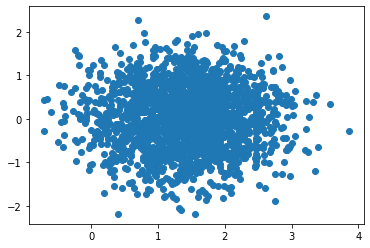

test samples: tensor([[ 2.3583, -1.7213],
        [ 0.0180, -0.6027],
        [-0.0717,  0.1086],
        ...,
        [ 2.3003,  2.2199],
        [ 2.1011, -1.2480],
        [-0.3716, -0.3029]])
auxil parameters: tensor([ 1.0000e+00,  1.0004e-04, -5.4139e-05,  9.9999e-01, -6.3604e-05,
         1.5633e-02], grad_fn=<CatBackward0>)
forward parameters: tensor([ 1.0000e+00,  1.0004e-04, -5.4139e-05,  9.9999e-01, -6.3604e-05,
         1.5633e-02], grad_fn=<CatBackward0>)
log det: tensor(-1.0157e-05, grad_fn=<LogBackward0>)
forward parameters: tensor([ 1.0000e+00,  1.0004e-04, -5.4139e-05,  9.9999e-01, -6.3604e-05,
         1.5633e-02], grad_fn=<CatBackward0>)
log det: tensor(-1.0157e-05, grad_fn=<LogBackward0>)
g1: (tensor([[1.2413e+05, 3.0648e+01],
        [1.1230e+03, 2.4971e+04]], grad_fn=<TBackward0>), tensor([70456.7455,   764.9907], grad_fn=<ViewBackward0>))
initial residual
forward parameters: tensor([ 1.0000e+00,  1.0004e-04, -5.4139e-05,  9.9999e-01, -6.3604e-05,
         1.5633e-

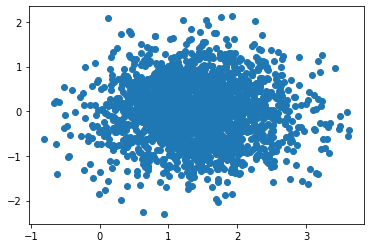

test samples: tensor([[ 0.6365,  0.8975],
        [ 1.9042, -0.0311],
        [ 2.0255, -0.2147],
        ...,
        [ 3.0359,  0.9847],
        [ 0.8749, -0.8756],
        [ 0.8370, -0.4957]])
auxil parameters: tensor([ 1.0000e+00,  1.0004e-04, -4.1184e-05,  9.9999e-01, -7.7514e-05,
         1.7029e-02], grad_fn=<CatBackward0>)
forward parameters: tensor([ 1.0000e+00,  1.0004e-04, -4.1184e-05,  9.9999e-01, -7.7514e-05,
         1.7029e-02], grad_fn=<CatBackward0>)
log det: tensor(-1.0702e-05, grad_fn=<LogBackward0>)
forward parameters: tensor([ 1.0000e+00,  1.0004e-04, -4.1184e-05,  9.9999e-01, -7.7514e-05,
         1.7029e-02], grad_fn=<CatBackward0>)
log det: tensor(-1.0702e-05, grad_fn=<LogBackward0>)
g1: (tensor([[124494.5490,   -168.3275],
        [  1026.6312,  25117.4663]], grad_fn=<TBackward0>), tensor([70616.0587,   686.7883], grad_fn=<ViewBackward0>))
initial residual
forward parameters: tensor([ 1.0000e+00,  1.0004e-04, -4.1184e-05,  9.9999e-01, -7.7514e-05,
         1.70

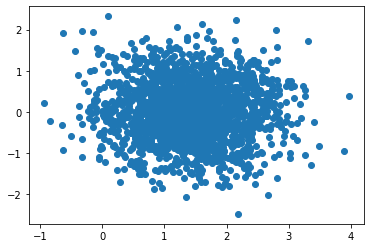

test samples: tensor([[ 1.6942, -0.3594],
        [ 0.7493, -0.8813],
        [ 2.0400,  0.7188],
        ...,
        [ 1.7308,  1.2223],
        [ 0.3816,  0.4325],
        [ 0.2387, -0.0205]])
auxil parameters: tensor([ 1.0000e+00,  9.9936e-05, -3.7342e-05,  1.0000e+00, -9.2974e-05,
         1.8438e-02], grad_fn=<CatBackward0>)
forward parameters: tensor([ 1.0000e+00,  9.9936e-05, -3.7342e-05,  1.0000e+00, -9.2974e-05,
         1.8438e-02], grad_fn=<CatBackward0>)
log det: tensor(-2.7471e-06, grad_fn=<LogBackward0>)
forward parameters: tensor([ 1.0000e+00,  9.9936e-05, -3.7342e-05,  1.0000e+00, -9.2974e-05,
         1.8438e-02], grad_fn=<CatBackward0>)
log det: tensor(-2.7471e-06, grad_fn=<LogBackward0>)
g1: (tensor([[1.2490e+05, 1.0017e+01],
        [1.3059e+03, 2.5048e+04]], grad_fn=<TBackward0>), tensor([70670.3808,   805.7503], grad_fn=<ViewBackward0>))
initial residual
forward parameters: tensor([ 1.0000e+00,  9.9936e-05, -3.7342e-05,  1.0000e+00, -9.2974e-05,
         1.8438e-

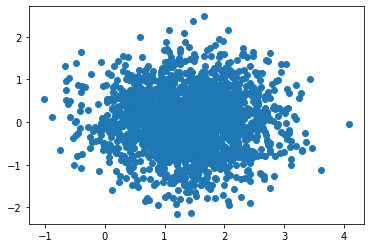

test samples: tensor([[ 0.7253, -0.6112],
        [ 1.0568,  0.7420],
        [ 2.4675, -0.1175],
        ...,
        [ 1.3124, -0.2280],
        [ 1.6293,  1.6080],
        [ 2.0855,  0.6224]])
auxil parameters: tensor([ 1.0000e+00,  9.9868e-05, -3.6672e-05,  1.0000e+00, -1.0990e-04,
         1.9851e-02], grad_fn=<CatBackward0>)
forward parameters: tensor([ 1.0000e+00,  9.9868e-05, -3.6672e-05,  1.0000e+00, -1.0990e-04,
         1.9851e-02], grad_fn=<CatBackward0>)
log det: tensor(2.5493e-06, grad_fn=<LogBackward0>)
forward parameters: tensor([ 1.0000e+00,  9.9868e-05, -3.6672e-05,  1.0000e+00, -1.0990e-04,
         1.9851e-02], grad_fn=<CatBackward0>)
log det: tensor(2.5493e-06, grad_fn=<LogBackward0>)
g1: (tensor([[1.2529e+05, 6.3703e+01],
        [1.4622e+03, 2.5307e+04]], grad_fn=<TBackward0>), tensor([70802.7851,   960.3188], grad_fn=<ViewBackward0>))
initial residual
forward parameters: tensor([ 1.0000e+00,  9.9868e-05, -3.6672e-05,  1.0000e+00, -1.0990e-04,
         1.9851e-02

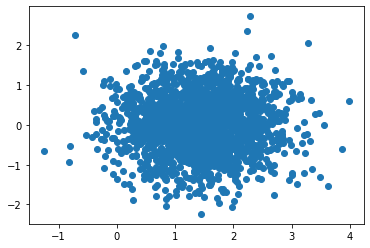

test samples: tensor([[ 1.9794,  0.8039],
        [ 2.2934, -0.4454],
        [ 1.9650,  0.7320],
        ...,
        [ 0.6391, -0.3291],
        [ 1.1860,  0.0148],
        [ 2.0446,  0.0363]])
auxil parameters: tensor([ 1.0000e+00,  9.9861e-05, -4.3501e-05,  1.0000e+00, -1.2838e-04,
         2.1275e-02], grad_fn=<CatBackward0>)
forward parameters: tensor([ 1.0000e+00,  9.9861e-05, -4.3501e-05,  1.0000e+00, -1.2838e-04,
         2.1275e-02], grad_fn=<CatBackward0>)
log det: tensor(3.2358e-06, grad_fn=<LogBackward0>)
forward parameters: tensor([ 1.0000e+00,  9.9861e-05, -4.3501e-05,  1.0000e+00, -1.2838e-04,
         2.1275e-02], grad_fn=<CatBackward0>)
log det: tensor(3.2358e-06, grad_fn=<LogBackward0>)
g1: (tensor([[125516.9652,   -178.9002],
        [  1322.4618,  25258.2312]], grad_fn=<TBackward0>), tensor([70939.8915,   811.4510], grad_fn=<ViewBackward0>))
initial residual
forward parameters: tensor([ 1.0000e+00,  9.9861e-05, -4.3501e-05,  1.0000e+00, -1.2838e-04,
         2.1275

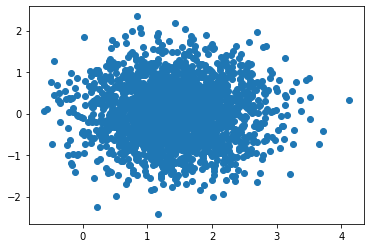

test samples: tensor([[-0.8680, -0.0310],
        [ 0.6978,  0.1926],
        [ 0.9593,  0.6412],
        ...,
        [ 1.0979, -0.4689],
        [ 1.5101, -1.4414],
        [ 0.9539, -0.3750]])
auxil parameters: tensor([ 1.0000e+00,  9.9681e-05, -5.8313e-05,  1.0000e+00, -1.4843e-04,
         2.2710e-02], grad_fn=<CatBackward0>)
forward parameters: tensor([ 1.0000e+00,  9.9681e-05, -5.8313e-05,  1.0000e+00, -1.4843e-04,
         2.2710e-02], grad_fn=<CatBackward0>)
log det: tensor(1.6399e-05, grad_fn=<LogBackward0>)
forward parameters: tensor([ 1.0000e+00,  9.9681e-05, -5.8313e-05,  1.0000e+00, -1.4843e-04,
         2.2710e-02], grad_fn=<CatBackward0>)
log det: tensor(1.6399e-05, grad_fn=<LogBackward0>)
g1: (tensor([[124516.1696,   -273.8127],
        [  1319.6129,  24882.7762]], grad_fn=<TBackward0>), tensor([70586.7371,   961.1754], grad_fn=<ViewBackward0>))
initial residual
forward parameters: tensor([ 1.0000e+00,  9.9681e-05, -5.8313e-05,  1.0000e+00, -1.4843e-04,
         2.2710

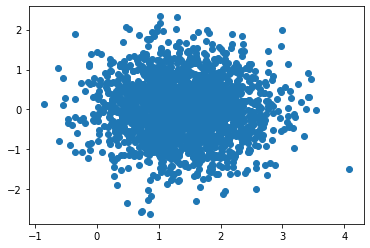

test samples: tensor([[ 1.7314,  0.2229],
        [ 1.3367,  0.4240],
        [ 0.8391, -1.2527],
        ...,
        [ 0.7197, -0.4532],
        [ 2.3863, -0.0748],
        [ 2.0025, -0.1127]])
auxil parameters: tensor([ 1.0000e+00,  9.9567e-05, -5.2990e-05,  1.0000e+00, -1.6947e-04,
         2.4117e-02], grad_fn=<CatBackward0>)
forward parameters: tensor([ 1.0000e+00,  9.9567e-05, -5.2990e-05,  1.0000e+00, -1.6947e-04,
         2.4117e-02], grad_fn=<CatBackward0>)
log det: tensor(2.4871e-05, grad_fn=<LogBackward0>)
forward parameters: tensor([ 1.0000e+00,  9.9567e-05, -5.2990e-05,  1.0000e+00, -1.6947e-04,
         2.4117e-02], grad_fn=<CatBackward0>)
log det: tensor(2.4871e-05, grad_fn=<LogBackward0>)
g1: (tensor([[ 1.2505e+05, -3.8683e+01],
        [ 1.6550e+03,  2.4837e+04]], grad_fn=<TBackward0>), tensor([70598.8596,  1196.6735], grad_fn=<ViewBackward0>))
initial residual
forward parameters: tensor([ 1.0000e+00,  9.9567e-05, -5.2990e-05,  1.0000e+00, -1.6947e-04,
         2.4117

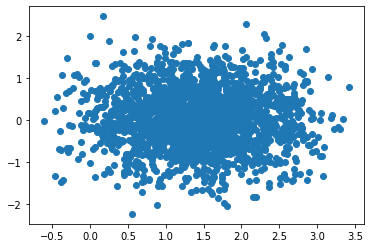

test samples: tensor([[ 1.4210,  0.9339],
        [ 3.2510, -0.2606],
        [ 0.3597,  0.9872],
        ...,
        [ 2.4134,  0.5697],
        [ 1.9090, -0.8729],
        [ 3.0052,  1.1956]])
auxil parameters: tensor([ 1.0000e+00,  9.9602e-05, -4.8519e-05,  1.0000e+00, -1.9195e-04,
         2.5524e-02], grad_fn=<CatBackward0>)
forward parameters: tensor([ 1.0000e+00,  9.9602e-05, -4.8519e-05,  1.0000e+00, -1.9195e-04,
         2.5524e-02], grad_fn=<CatBackward0>)
log det: tensor(2.3990e-05, grad_fn=<LogBackward0>)
forward parameters: tensor([ 1.0000e+00,  9.9602e-05, -4.8519e-05,  1.0000e+00, -1.9195e-04,
         2.5524e-02], grad_fn=<CatBackward0>)
log det: tensor(2.3990e-05, grad_fn=<LogBackward0>)
g1: (tensor([[124457.6818,   -192.4080],
        [  1597.9394,  25070.3319]], grad_fn=<TBackward0>), tensor([70469.5357,  1049.5721], grad_fn=<ViewBackward0>))
initial residual
forward parameters: tensor([ 1.0000e+00,  9.9602e-05, -4.8519e-05,  1.0000e+00, -1.9195e-04,
         2.5524

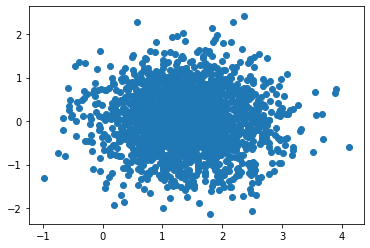

test samples: tensor([[ 1.3152, -0.5105],
        [ 1.5645, -0.4316],
        [ 0.7145, -0.1525],
        ...,
        [ 0.6957, -0.4580],
        [ 0.2856, -0.4412],
        [ 1.2609, -0.2702]])
auxil parameters: tensor([ 1.0000e+00,  9.9430e-05, -3.6848e-05,  1.0000e+00, -2.1566e-04,
         2.6922e-02], grad_fn=<CatBackward0>)
forward parameters: tensor([ 1.0000e+00,  9.9430e-05, -3.6848e-05,  1.0000e+00, -2.1566e-04,
         2.6922e-02], grad_fn=<CatBackward0>)
log det: tensor(3.5214e-05, grad_fn=<LogBackward0>)
forward parameters: tensor([ 1.0000e+00,  9.9430e-05, -3.6848e-05,  1.0000e+00, -2.1566e-04,
         2.6922e-02], grad_fn=<CatBackward0>)
log det: tensor(3.5214e-05, grad_fn=<LogBackward0>)
g1: (tensor([[ 1.2512e+05, -1.9733e+01],
        [ 1.8799e+03,  2.5301e+04]], grad_fn=<TBackward0>), tensor([70814.9348,  1334.6262], grad_fn=<ViewBackward0>))
initial residual
forward parameters: tensor([ 1.0000e+00,  9.9430e-05, -3.6848e-05,  1.0000e+00, -2.1566e-04,
         2.6922

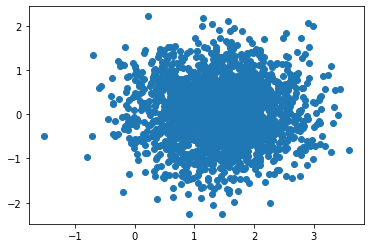

test samples: tensor([[ 1.0723,  0.4935],
        [ 0.4884, -1.1279],
        [ 0.2230, -0.1252],
        ...,
        [ 1.3286,  0.6451],
        [ 1.0789,  0.8993],
        [ 2.2906, -1.1049]])
auxil parameters: tensor([ 1.0000e+00,  9.9473e-05, -4.4727e-05,  1.0000e+00, -2.4129e-04,
         2.8347e-02], grad_fn=<CatBackward0>)
forward parameters: tensor([ 1.0000e+00,  9.9473e-05, -4.4727e-05,  1.0000e+00, -2.4129e-04,
         2.8347e-02], grad_fn=<CatBackward0>)
log det: tensor(3.4761e-05, grad_fn=<LogBackward0>)
forward parameters: tensor([ 1.0000e+00,  9.9473e-05, -4.4727e-05,  1.0000e+00, -2.4129e-04,
         2.8347e-02], grad_fn=<CatBackward0>)
log det: tensor(3.4761e-05, grad_fn=<LogBackward0>)
g1: (tensor([[124552.6590,    262.2924],
        [  2255.4139,  25082.1348]], grad_fn=<TBackward0>), tensor([70582.0860,  1597.7346], grad_fn=<ViewBackward0>))
initial residual
forward parameters: tensor([ 1.0000e+00,  9.9473e-05, -4.4727e-05,  1.0000e+00, -2.4129e-04,
         2.8347

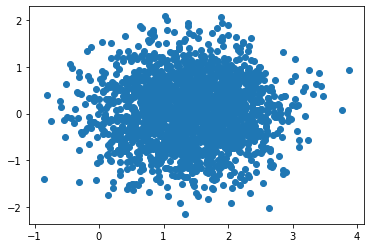

test samples: tensor([[-0.0319,  0.8134],
        [ 2.3837,  0.1877],
        [ 1.4462, -0.0448],
        ...,
        [ 0.5986,  0.9505],
        [ 1.7143, -0.5249],
        [ 0.7952,  0.0453]])
auxil parameters: tensor([ 1.0000e+00,  9.9723e-05, -3.9425e-05,  1.0000e+00, -2.6797e-04,
         2.9754e-02], grad_fn=<CatBackward0>)
forward parameters: tensor([ 1.0000e+00,  9.9723e-05, -3.9425e-05,  1.0000e+00, -2.6797e-04,
         2.9754e-02], grad_fn=<CatBackward0>)
log det: tensor(2.3207e-05, grad_fn=<LogBackward0>)
forward parameters: tensor([ 1.0000e+00,  9.9723e-05, -3.9425e-05,  1.0000e+00, -2.6797e-04,
         2.9754e-02], grad_fn=<CatBackward0>)
log det: tensor(2.3207e-05, grad_fn=<LogBackward0>)
g1: (tensor([[1.2526e+05, 7.0128e+01],
        [2.1709e+03, 2.5087e+04]], grad_fn=<TBackward0>), tensor([70841.3148,  1472.6744], grad_fn=<ViewBackward0>))
initial residual
forward parameters: tensor([ 1.0000e+00,  9.9723e-05, -3.9425e-05,  1.0000e+00, -2.6797e-04,
         2.9754e-02

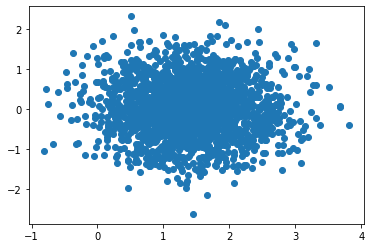

test samples: tensor([[ 2.8084e+00,  1.1211e+00],
        [ 7.1129e-01, -9.0634e-01],
        [ 2.4387e+00,  3.8472e-01],
        ...,
        [ 1.4771e+00, -1.2187e-01],
        [ 4.5042e-01,  8.4904e-04],
        [ 3.0072e-01,  4.7351e-01]])
auxil parameters: tensor([ 1.0000e+00,  9.9752e-05, -4.8930e-05,  1.0000e+00, -2.9648e-04,
         3.1181e-02], grad_fn=<CatBackward0>)
forward parameters: tensor([ 1.0000e+00,  9.9752e-05, -4.8930e-05,  1.0000e+00, -2.9648e-04,
         3.1181e-02], grad_fn=<CatBackward0>)
log det: tensor(2.3018e-05, grad_fn=<LogBackward0>)
forward parameters: tensor([ 1.0000e+00,  9.9752e-05, -4.8930e-05,  1.0000e+00, -2.9648e-04,
         3.1181e-02], grad_fn=<CatBackward0>)
log det: tensor(2.3018e-05, grad_fn=<LogBackward0>)
g1: (tensor([[125318.9256,    236.1821],
        [  2437.2443,  24884.1688]], grad_fn=<TBackward0>), tensor([70850.6516,  1632.0305], grad_fn=<ViewBackward0>))
initial residual
forward parameters: tensor([ 1.0000e+00,  9.9752e-05, -4.893

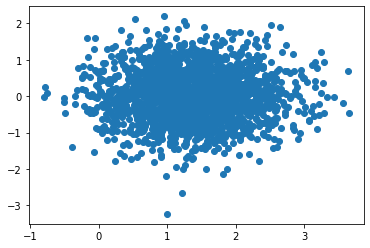

test samples: tensor([[ 2.6936, -0.6720],
        [ 0.1823, -0.0839],
        [ 2.8954, -1.3617],
        ...,
        [ 2.5862, -0.3258],
        [ 1.2197,  1.7511],
        [ 0.4691, -1.1627]])
auxil parameters: tensor([ 1.0000e+00,  9.9886e-05, -5.9008e-05,  1.0000e+00, -3.2643e-04,
         3.2609e-02], grad_fn=<CatBackward0>)
forward parameters: tensor([ 1.0000e+00,  9.9886e-05, -5.9008e-05,  1.0000e+00, -3.2643e-04,
         3.2609e-02], grad_fn=<CatBackward0>)
log det: tensor(1.7820e-05, grad_fn=<LogBackward0>)
forward parameters: tensor([ 1.0000e+00,  9.9886e-05, -5.9008e-05,  1.0000e+00, -3.2643e-04,
         3.2609e-02], grad_fn=<CatBackward0>)
log det: tensor(1.7820e-05, grad_fn=<LogBackward0>)
g1: (tensor([[124448.8829,   -142.4970],
        [  2146.8273,  24838.4669]], grad_fn=<TBackward0>), tensor([70490.6651,  1584.5366], grad_fn=<ViewBackward0>))
initial residual
forward parameters: tensor([ 1.0000e+00,  9.9886e-05, -5.9008e-05,  1.0000e+00, -3.2643e-04,
         3.2609

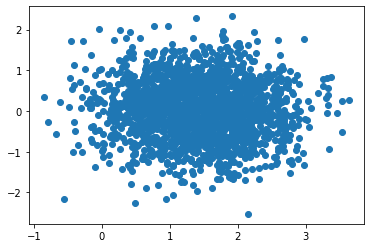

test samples: tensor([[ 0.6697,  0.0062],
        [ 2.4486, -0.2384],
        [ 1.0017, -0.6210],
        ...,
        [ 0.5780, -0.6066],
        [ 2.0453,  0.2596],
        [ 0.2585,  0.8452]])
auxil parameters: tensor([ 1.0000e+00,  9.9872e-05, -4.8815e-05,  1.0000e+00, -3.5716e-04,
         3.4009e-02], grad_fn=<CatBackward0>)
forward parameters: tensor([ 1.0000e+00,  9.9872e-05, -4.8815e-05,  1.0000e+00, -3.5716e-04,
         3.4009e-02], grad_fn=<CatBackward0>)
log det: tensor(1.8877e-05, grad_fn=<LogBackward0>)
forward parameters: tensor([ 1.0000e+00,  9.9872e-05, -4.8815e-05,  1.0000e+00, -3.5716e-04,
         3.4009e-02], grad_fn=<CatBackward0>)
log det: tensor(1.8877e-05, grad_fn=<LogBackward0>)
g1: (tensor([[ 1.2473e+05, -8.8018e+01],
        [ 2.3079e+03,  2.5253e+04]], grad_fn=<TBackward0>), tensor([70685.2453,  1699.6595], grad_fn=<ViewBackward0>))
initial residual
forward parameters: tensor([ 1.0000e+00,  9.9872e-05, -4.8815e-05,  1.0000e+00, -3.5716e-04,
         3.4009

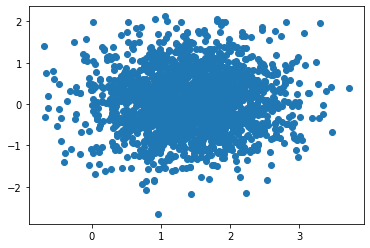

test samples: tensor([[ 2.2354,  2.0915],
        [ 0.4323,  0.1263],
        [ 1.5642,  0.2926],
        ...,
        [ 0.9854, -0.7554],
        [ 1.6700,  0.1795],
        [ 0.5593,  0.3665]])
auxil parameters: tensor([ 1.0000e+00,  9.9917e-05, -4.9711e-05,  1.0000e+00, -3.8967e-04,
         3.5424e-02], grad_fn=<CatBackward0>)
forward parameters: tensor([ 1.0000e+00,  9.9917e-05, -4.9711e-05,  1.0000e+00, -3.8967e-04,
         3.5424e-02], grad_fn=<CatBackward0>)
log det: tensor(1.7642e-05, grad_fn=<LogBackward0>)
forward parameters: tensor([ 1.0000e+00,  9.9917e-05, -4.9711e-05,  1.0000e+00, -3.8967e-04,
         3.5424e-02], grad_fn=<CatBackward0>)
log det: tensor(1.7642e-05, grad_fn=<LogBackward0>)
g1: (tensor([[124936.9071,   -273.2503],
        [  2222.4158,  24844.4363]], grad_fn=<TBackward0>), tensor([70679.2689,  1667.1033], grad_fn=<ViewBackward0>))
initial residual
forward parameters: tensor([ 1.0000e+00,  9.9917e-05, -4.9711e-05,  1.0000e+00, -3.8967e-04,
         3.5424

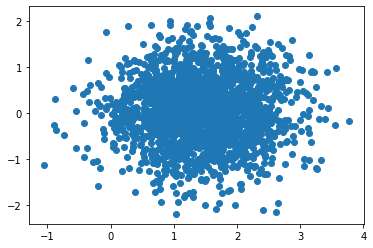

test samples: tensor([[ 1.8499, -0.0405],
        [ 0.2394,  0.0860],
        [ 1.6261,  0.7116],
        ...,
        [ 0.7354,  0.2566],
        [ 0.7271, -0.1043],
        [ 0.8904, -1.3235]])
auxil parameters: tensor([ 1.0000e+00,  9.9820e-05, -5.0324e-05,  1.0000e+00, -4.2357e-04,
         3.6838e-02], grad_fn=<CatBackward0>)
forward parameters: tensor([ 1.0000e+00,  9.9820e-05, -5.0324e-05,  1.0000e+00, -4.2357e-04,
         3.6838e-02], grad_fn=<CatBackward0>)
log det: tensor(2.2255e-05, grad_fn=<LogBackward0>)
forward parameters: tensor([ 1.0000e+00,  9.9820e-05, -5.0324e-05,  1.0000e+00, -4.2357e-04,
         3.6838e-02], grad_fn=<CatBackward0>)
log det: tensor(2.2255e-05, grad_fn=<LogBackward0>)
g1: (tensor([[125313.6048,   -277.9870],
        [  2325.3359,  25246.4935]], grad_fn=<TBackward0>), tensor([70890.3580,  1601.9755], grad_fn=<ViewBackward0>))
initial residual
forward parameters: tensor([ 1.0000e+00,  9.9820e-05, -5.0324e-05,  1.0000e+00, -4.2357e-04,
         3.6838

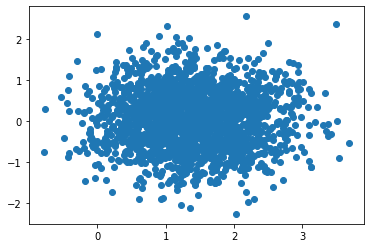

test samples: tensor([[ 1.4236,  0.0902],
        [ 1.0881,  1.6819],
        [ 1.8004,  0.8117],
        ...,
        [ 1.3397,  0.3022],
        [ 1.7330, -0.8268],
        [ 0.9696, -0.6255]])
auxil parameters: tensor([ 1.0000e+00,  9.9535e-05, -6.3138e-05,  1.0000e+00, -4.5933e-04,
         3.8270e-02], grad_fn=<CatBackward0>)
forward parameters: tensor([ 1.0000e+00,  9.9535e-05, -6.3138e-05,  1.0000e+00, -4.5933e-04,
         3.8270e-02], grad_fn=<CatBackward0>)
log det: tensor(3.4733e-05, grad_fn=<LogBackward0>)
forward parameters: tensor([ 1.0000e+00,  9.9535e-05, -6.3138e-05,  1.0000e+00, -4.5933e-04,
         3.8270e-02], grad_fn=<CatBackward0>)
log det: tensor(3.4733e-05, grad_fn=<LogBackward0>)
g1: (tensor([[124889.3940,   -148.3439],
        [  2548.8453,  25197.8726]], grad_fn=<TBackward0>), tensor([70726.2485,  1913.8476], grad_fn=<ViewBackward0>))
initial residual
forward parameters: tensor([ 1.0000e+00,  9.9535e-05, -6.3138e-05,  1.0000e+00, -4.5933e-04,
         3.8270

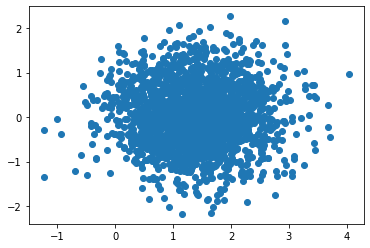

test samples: tensor([[ 0.5773, -0.5405],
        [ 1.2360,  0.3165],
        [ 1.6724, -0.7973],
        ...,
        [ 1.4416, -0.7306],
        [ 0.8994, -0.0034],
        [ 0.9389,  0.8402]])
auxil parameters: tensor([ 1.0000e+00,  9.9602e-05, -6.6663e-05,  1.0000e+00, -4.9616e-04,
         3.9689e-02], grad_fn=<CatBackward0>)
forward parameters: tensor([ 1.0000e+00,  9.9602e-05, -6.6663e-05,  1.0000e+00, -4.9616e-04,
         3.9689e-02], grad_fn=<CatBackward0>)
log det: tensor(3.3415e-05, grad_fn=<LogBackward0>)
forward parameters: tensor([ 1.0000e+00,  9.9602e-05, -6.6663e-05,  1.0000e+00, -4.9616e-04,
         3.9689e-02], grad_fn=<CatBackward0>)
log det: tensor(3.3415e-05, grad_fn=<LogBackward0>)
g1: (tensor([[1.2541e+05, 2.6217e+01],
        [2.8245e+03, 2.5170e+04]], grad_fn=<TBackward0>), tensor([70753.8849,  2085.7011], grad_fn=<ViewBackward0>))
initial residual
forward parameters: tensor([ 1.0000e+00,  9.9602e-05, -6.6663e-05,  1.0000e+00, -4.9616e-04,
         3.9689e-02

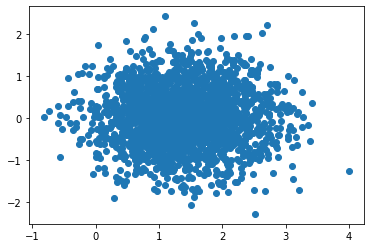

test samples: tensor([[ 2.1789, -0.0371],
        [ 1.4314,  1.1050],
        [ 1.8984,  1.3577],
        ...,
        [ 0.9107,  0.6943],
        [ 2.1210, -0.1078],
        [ 2.6900, -0.7983]])
auxil parameters: tensor([ 1.0000e+00,  9.9823e-05, -7.1803e-05,  1.0000e+00, -5.3447e-04,
         4.1110e-02], grad_fn=<CatBackward0>)
forward parameters: tensor([ 1.0000e+00,  9.9823e-05, -7.1803e-05,  1.0000e+00, -5.3447e-04,
         4.1110e-02], grad_fn=<CatBackward0>)
log det: tensor(2.6454e-05, grad_fn=<LogBackward0>)
forward parameters: tensor([ 1.0000e+00,  9.9823e-05, -7.1803e-05,  1.0000e+00, -5.3447e-04,
         4.1110e-02], grad_fn=<CatBackward0>)
log det: tensor(2.6454e-05, grad_fn=<LogBackward0>)
g1: (tensor([[124600.2791,    190.8199],
        [  3082.5873,  25256.9270]], grad_fn=<TBackward0>), tensor([70593.2988,  2151.5391], grad_fn=<ViewBackward0>))
initial residual
forward parameters: tensor([ 1.0000e+00,  9.9823e-05, -7.1803e-05,  1.0000e+00, -5.3447e-04,
         4.1110

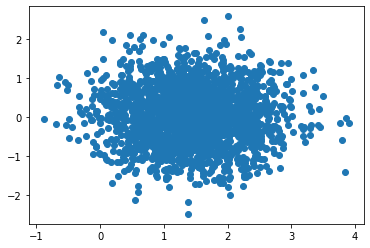

test samples: tensor([[ 1.2187, -0.3775],
        [ 1.0083,  0.5615],
        [ 1.4507, -0.0325],
        ...,
        [ 1.1662,  0.2373],
        [ 1.8547,  0.9889],
        [ 1.7532, -0.4653]])
auxil parameters: tensor([ 1.0000e+00,  1.0003e-04, -6.7959e-05,  1.0000e+00, -5.7383e-04,
         4.2518e-02], grad_fn=<CatBackward0>)
forward parameters: tensor([ 1.0000e+00,  1.0003e-04, -6.7959e-05,  1.0000e+00, -5.7383e-04,
         4.2518e-02], grad_fn=<CatBackward0>)
log det: tensor(1.9553e-05, grad_fn=<LogBackward0>)
forward parameters: tensor([ 1.0000e+00,  1.0003e-04, -6.7959e-05,  1.0000e+00, -5.7383e-04,
         4.2518e-02], grad_fn=<CatBackward0>)
log det: tensor(1.9553e-05, grad_fn=<LogBackward0>)
g1: (tensor([[125241.8986,   -181.9259],
        [  2813.1041,  25021.0448]], grad_fn=<TBackward0>), tensor([70673.1081,  2028.6214], grad_fn=<ViewBackward0>))
initial residual
forward parameters: tensor([ 1.0000e+00,  1.0003e-04, -6.7959e-05,  1.0000e+00, -5.7383e-04,
         4.2518

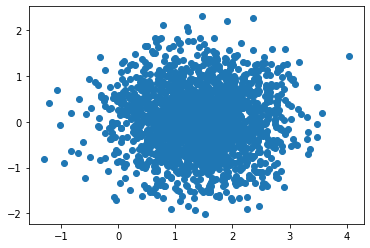

test samples: tensor([[ 1.6169, -0.3943],
        [ 2.1260,  1.0866],
        [ 2.0386, -0.0534],
        ...,
        [ 1.5711,  0.7592],
        [ 1.5973,  0.2752],
        [ 2.0178, -0.5347]])
auxil parameters: tensor([ 1.0000e+00,  9.9931e-05, -6.8750e-05,  1.0000e+00, -6.1480e-04,
         4.3933e-02], grad_fn=<CatBackward0>)
forward parameters: tensor([ 1.0000e+00,  9.9931e-05, -6.8750e-05,  1.0000e+00, -6.1480e-04,
         4.3933e-02], grad_fn=<CatBackward0>)
log det: tensor(2.3668e-05, grad_fn=<LogBackward0>)
forward parameters: tensor([ 1.0000e+00,  9.9931e-05, -6.8750e-05,  1.0000e+00, -6.1480e-04,
         4.3933e-02], grad_fn=<CatBackward0>)
log det: tensor(2.3668e-05, grad_fn=<LogBackward0>)
g1: (tensor([[1.2497e+05, 1.0161e+02],
        [3.1958e+03, 2.4719e+04]], grad_fn=<TBackward0>), tensor([70651.0203,  2217.0736], grad_fn=<ViewBackward0>))
initial residual
forward parameters: tensor([ 1.0000e+00,  9.9931e-05, -6.8750e-05,  1.0000e+00, -6.1480e-04,
         4.3933e-02

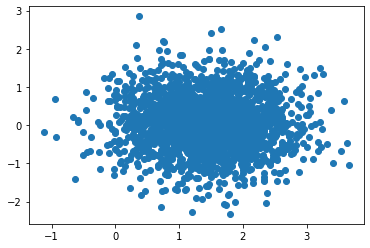

test samples: tensor([[ 1.5548,  0.6420],
        [ 0.8601,  1.3441],
        [ 0.9581, -0.3439],
        ...,
        [ 1.0574, -0.7441],
        [ 1.2705, -0.5115],
        [ 1.5390, -0.0659]])
auxil parameters: tensor([ 1.0000e+00,  1.0003e-04, -6.8422e-05,  1.0000e+00, -6.5713e-04,
         4.5346e-02], grad_fn=<CatBackward0>)
forward parameters: tensor([ 1.0000e+00,  1.0003e-04, -6.8422e-05,  1.0000e+00, -6.5713e-04,
         4.5346e-02], grad_fn=<CatBackward0>)
log det: tensor(2.1066e-05, grad_fn=<LogBackward0>)
forward parameters: tensor([ 1.0000e+00,  1.0003e-04, -6.8422e-05,  1.0000e+00, -6.5713e-04,
         4.5346e-02], grad_fn=<CatBackward0>)
log det: tensor(2.1066e-05, grad_fn=<LogBackward0>)
g1: (tensor([[124032.4246,   -312.6307],
        [  2868.9121,  25141.6888]], grad_fn=<TBackward0>), tensor([70372.9747,  2174.8936], grad_fn=<ViewBackward0>))
initial residual
forward parameters: tensor([ 1.0000e+00,  1.0003e-04, -6.8422e-05,  1.0000e+00, -6.5713e-04,
         4.5346

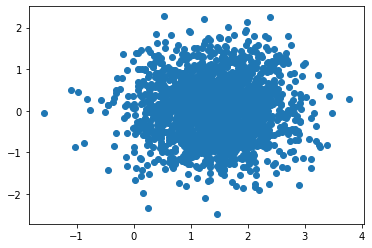

test samples: tensor([[ 1.7480, -0.1975],
        [-0.1039, -0.4858],
        [ 2.0137,  1.3352],
        ...,
        [ 1.5483,  1.2379],
        [ 1.4057,  0.3197],
        [ 1.6729,  0.2816]])
auxil parameters: tensor([ 1.0000e+00,  9.9922e-05, -5.2429e-05,  1.0000e+00, -7.0019e-04,
         4.6737e-02], grad_fn=<CatBackward0>)
forward parameters: tensor([ 1.0000e+00,  9.9922e-05, -5.2429e-05,  1.0000e+00, -7.0019e-04,
         4.6737e-02], grad_fn=<CatBackward0>)
log det: tensor(2.4487e-05, grad_fn=<LogBackward0>)
forward parameters: tensor([ 1.0000e+00,  9.9922e-05, -5.2429e-05,  1.0000e+00, -7.0019e-04,
         4.6737e-02], grad_fn=<CatBackward0>)
log det: tensor(2.4487e-05, grad_fn=<LogBackward0>)
g1: (tensor([[126133.3117,   -444.0235],
        [  2869.9723,  25035.5834]], grad_fn=<TBackward0>), tensor([71070.0052,  2191.5012], grad_fn=<ViewBackward0>))
initial residual
forward parameters: tensor([ 1.0000e+00,  9.9922e-05, -5.2429e-05,  1.0000e+00, -7.0019e-04,
         4.6737

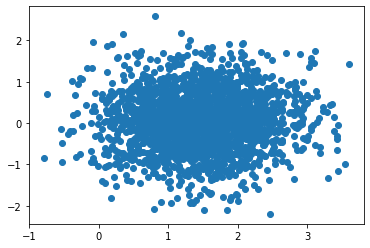

test samples: tensor([[ 2.7889, -1.7545],
        [ 1.8846, -1.0743],
        [ 1.3007,  0.4026],
        ...,
        [ 1.7657, -0.7587],
        [ 1.5567,  0.1421],
        [ 3.4655, -0.1534]])
auxil parameters: tensor([ 1.0000e+00,  9.9730e-05, -7.5912e-05,  1.0000e+00, -7.4645e-04,
         4.8184e-02], grad_fn=<CatBackward0>)
forward parameters: tensor([ 1.0000e+00,  9.9730e-05, -7.5912e-05,  1.0000e+00, -7.4645e-04,
         4.8184e-02], grad_fn=<CatBackward0>)
log det: tensor(3.1890e-05, grad_fn=<LogBackward0>)
forward parameters: tensor([ 1.0000e+00,  9.9730e-05, -7.5912e-05,  1.0000e+00, -7.4645e-04,
         4.8184e-02], grad_fn=<CatBackward0>)
log det: tensor(3.1890e-05, grad_fn=<LogBackward0>)
g1: (tensor([[1.2499e+05, 7.1531e+01],
        [3.4667e+03, 2.4859e+04]], grad_fn=<TBackward0>), tensor([70673.0453,  2486.5870], grad_fn=<ViewBackward0>))
initial residual
forward parameters: tensor([ 1.0000e+00,  9.9730e-05, -7.5912e-05,  1.0000e+00, -7.4645e-04,
         4.8184e-02

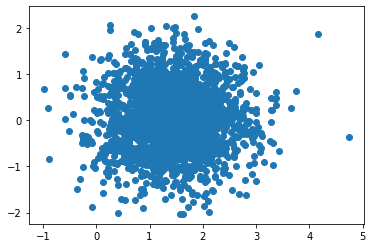

test samples: tensor([[ 1.5176, -0.4846],
        [ 0.8478, -0.9434],
        [ 2.1560, -0.5514],
        ...,
        [ 1.2566,  0.7689],
        [ 1.0107,  0.2346],
        [ 1.8909, -0.6914]])
auxil parameters: tensor([ 1.0000e+00,  9.9950e-05, -7.7215e-05,  1.0000e+00, -7.9309e-04,
         4.9599e-02], grad_fn=<CatBackward0>)
forward parameters: tensor([ 1.0000e+00,  9.9950e-05, -7.7215e-05,  1.0000e+00, -7.9309e-04,
         4.9599e-02], grad_fn=<CatBackward0>)
log det: tensor(2.6077e-05, grad_fn=<LogBackward0>)
forward parameters: tensor([ 1.0000e+00,  9.9950e-05, -7.7215e-05,  1.0000e+00, -7.9309e-04,
         4.9599e-02], grad_fn=<CatBackward0>)
log det: tensor(2.6077e-05, grad_fn=<LogBackward0>)
g1: (tensor([[124401.7210,   -285.8491],
        [  3201.2981,  24769.0932]], grad_fn=<TBackward0>), tensor([70513.7819,  2305.8535], grad_fn=<ViewBackward0>))
initial residual
forward parameters: tensor([ 1.0000e+00,  9.9950e-05, -7.7215e-05,  1.0000e+00, -7.9309e-04,
         4.9599

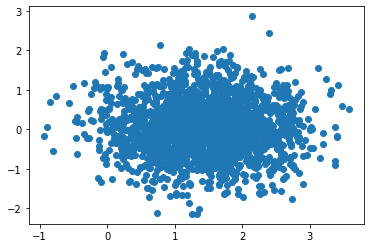

test samples: tensor([[ 0.7692, -1.3224],
        [ 0.6382, -0.5900],
        [ 2.1261,  0.3419],
        ...,
        [ 0.5432,  1.0720],
        [ 1.7349,  0.4944],
        [ 0.6700, -0.2932]])
auxil parameters: tensor([ 1.0000e+00,  9.9682e-05, -6.9591e-05,  1.0000e+00, -8.4071e-04,
         5.1002e-02], grad_fn=<CatBackward0>)
forward parameters: tensor([ 1.0000e+00,  9.9682e-05, -6.9591e-05,  1.0000e+00, -8.4071e-04,
         5.1002e-02], grad_fn=<CatBackward0>)
log det: tensor(3.4301e-05, grad_fn=<LogBackward0>)
forward parameters: tensor([ 1.0000e+00,  9.9682e-05, -6.9591e-05,  1.0000e+00, -8.4071e-04,
         5.1002e-02], grad_fn=<CatBackward0>)
log det: tensor(3.4301e-05, grad_fn=<LogBackward0>)
g1: (tensor([[ 1.2555e+05, -3.9835e+01],
        [ 3.5696e+03,  2.4834e+04]], grad_fn=<TBackward0>), tensor([70949.7832,  2522.7293], grad_fn=<ViewBackward0>))
initial residual
forward parameters: tensor([ 1.0000e+00,  9.9682e-05, -6.9591e-05,  1.0000e+00, -8.4071e-04,
         5.1002

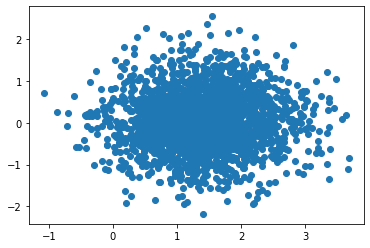

test samples: tensor([[ 2.1123, -0.0085],
        [ 0.0254, -0.2657],
        [ 1.0671,  0.3925],
        ...,
        [ 1.4186,  0.7041],
        [ 0.5379, -1.6993],
        [ 0.6596,  0.9929]])
auxil parameters: tensor([ 1.0000e+00,  9.9707e-05, -8.6929e-05,  1.0000e+00, -8.9099e-04,
         5.2439e-02], grad_fn=<CatBackward0>)
forward parameters: tensor([ 1.0000e+00,  9.9707e-05, -8.6929e-05,  1.0000e+00, -8.9099e-04,
         5.2439e-02], grad_fn=<CatBackward0>)
log det: tensor(3.5036e-05, grad_fn=<LogBackward0>)
forward parameters: tensor([ 1.0000e+00,  9.9707e-05, -8.6929e-05,  1.0000e+00, -8.9099e-04,
         5.2439e-02], grad_fn=<CatBackward0>)
log det: tensor(3.5036e-05, grad_fn=<LogBackward0>)
g1: (tensor([[124821.3994,   -207.0845],
        [  3479.1614,  25204.4456]], grad_fn=<TBackward0>), tensor([70507.4030,  2523.0683], grad_fn=<ViewBackward0>))
initial residual
forward parameters: tensor([ 1.0000e+00,  9.9707e-05, -8.6929e-05,  1.0000e+00, -8.9099e-04,
         5.2439

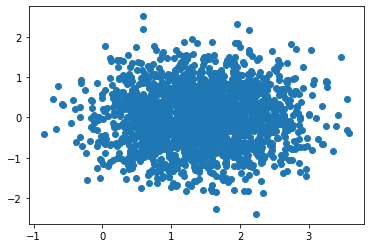

test samples: tensor([[ 1.8549,  0.8787],
        [ 1.8185,  0.1207],
        [ 1.3924,  0.0492],
        ...,
        [ 1.6980,  0.1303],
        [ 2.4263, -0.2290],
        [ 2.4278, -0.0096]])
auxil parameters: tensor([ 1.0000e+00,  9.9588e-05, -7.9356e-05,  1.0000e+00, -9.4141e-04,
         5.3842e-02], grad_fn=<CatBackward0>)
forward parameters: tensor([ 1.0000e+00,  9.9588e-05, -7.9356e-05,  1.0000e+00, -9.4141e-04,
         5.3842e-02], grad_fn=<CatBackward0>)
log det: tensor(3.8846e-05, grad_fn=<LogBackward0>)
forward parameters: tensor([ 1.0000e+00,  9.9588e-05, -7.9356e-05,  1.0000e+00, -9.4141e-04,
         5.3842e-02], grad_fn=<CatBackward0>)
log det: tensor(3.8846e-05, grad_fn=<LogBackward0>)
g1: (tensor([[1.2484e+05, 6.8363e+01],
        [3.8574e+03, 2.5044e+04]], grad_fn=<TBackward0>), tensor([70554.8810,  2774.6733], grad_fn=<ViewBackward0>))
initial residual
forward parameters: tensor([ 1.0000e+00,  9.9588e-05, -7.9356e-05,  1.0000e+00, -9.4141e-04,
         5.3842e-02

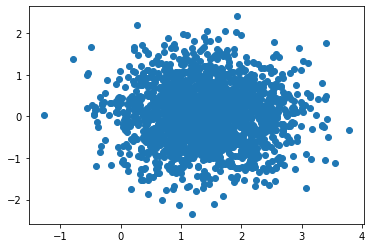

test samples: tensor([[ 2.0937, -0.9652],
        [ 1.2814,  0.0136],
        [ 1.5689,  0.1246],
        ...,
        [ 1.5143, -1.0092],
        [ 1.4342, -0.1612],
        [ 2.5765,  1.9870]])
auxil parameters: tensor([ 1.0000e+00,  9.9847e-05, -7.4577e-05,  1.0000e+00, -9.9338e-04,
         5.5248e-02], grad_fn=<CatBackward0>)
forward parameters: tensor([ 1.0000e+00,  9.9847e-05, -7.4577e-05,  1.0000e+00, -9.9338e-04,
         5.5248e-02], grad_fn=<CatBackward0>)
log det: tensor(3.2562e-05, grad_fn=<LogBackward0>)
forward parameters: tensor([ 1.0000e+00,  9.9847e-05, -7.4577e-05,  1.0000e+00, -9.9338e-04,
         5.5248e-02], grad_fn=<CatBackward0>)
log det: tensor(3.2562e-05, grad_fn=<LogBackward0>)
g1: (tensor([[125028.9160,    466.3490],
        [  4360.9870,  25112.3167]], grad_fn=<TBackward0>), tensor([70653.8008,  2956.8127], grad_fn=<ViewBackward0>))
initial residual
forward parameters: tensor([ 1.0000e+00,  9.9847e-05, -7.4577e-05,  1.0000e+00, -9.9338e-04,
         5.5248

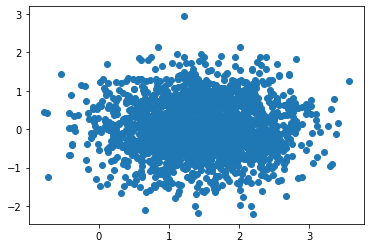

test samples: tensor([[ 0.9889,  0.3886],
        [ 1.8526, -1.3093],
        [ 0.2270, -0.0661],
        ...,
        [ 1.6690, -0.3493],
        [ 1.1953, -0.7245],
        [ 0.4644, -0.2918]])
auxil parameters: tensor([ 1.0000e+00,  1.0035e-04, -7.5389e-05,  1.0000e+00, -1.0471e-03,
         5.6663e-02], grad_fn=<CatBackward0>)
forward parameters: tensor([ 1.0000e+00,  1.0035e-04, -7.5389e-05,  1.0000e+00, -1.0471e-03,
         5.6663e-02], grad_fn=<CatBackward0>)
log det: tensor(2.0224e-05, grad_fn=<LogBackward0>)
forward parameters: tensor([ 1.0000e+00,  1.0035e-04, -7.5389e-05,  1.0000e+00, -1.0471e-03,
         5.6663e-02], grad_fn=<CatBackward0>)
log det: tensor(2.0224e-05, grad_fn=<LogBackward0>)
g1: (tensor([[1.2512e+05, 9.8939e+00],
        [4.0049e+03, 2.4997e+04]], grad_fn=<TBackward0>), tensor([70660.2719,  2986.7836], grad_fn=<ViewBackward0>))
initial residual
forward parameters: tensor([ 1.0000e+00,  1.0035e-04, -7.5389e-05,  1.0000e+00, -1.0471e-03,
         5.6663e-02

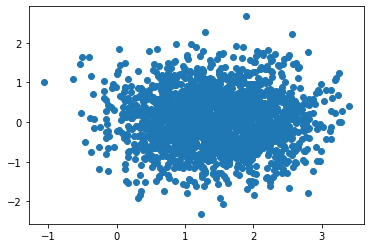

test samples: tensor([[ 1.2832, -0.4669],
        [ 1.1694,  0.8547],
        [ 1.4999,  0.2262],
        ...,
        [ 1.7160, -0.1863],
        [ 1.1480,  0.6753],
        [ 0.5645,  0.5022]])
auxil parameters: tensor([ 1.0000e+00,  1.0076e-04, -7.6887e-05,  1.0000e+00, -1.1022e-03,
         5.8078e-02], grad_fn=<CatBackward0>)
forward parameters: tensor([ 1.0000e+00,  1.0076e-04, -7.6887e-05,  1.0000e+00, -1.1022e-03,
         5.8078e-02], grad_fn=<CatBackward0>)
log det: tensor(1.0140e-05, grad_fn=<LogBackward0>)
forward parameters: tensor([ 1.0000e+00,  1.0076e-04, -7.6887e-05,  1.0000e+00, -1.1022e-03,
         5.8078e-02], grad_fn=<CatBackward0>)
log det: tensor(1.0140e-05, grad_fn=<LogBackward0>)
g1: (tensor([[1.2465e+05, 1.1084e+01],
        [4.1017e+03, 2.5074e+04]], grad_fn=<TBackward0>), tensor([70588.8365,  2817.4076], grad_fn=<ViewBackward0>))
initial residual
forward parameters: tensor([ 1.0000e+00,  1.0076e-04, -7.6887e-05,  1.0000e+00, -1.1022e-03,
         5.8078e-02

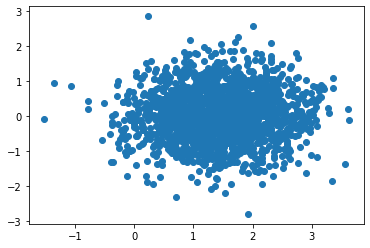

test samples: tensor([[ 1.4072,  0.3174],
        [ 2.4599,  0.9802],
        [ 0.8015, -0.7100],
        ...,
        [ 2.1545, -0.8402],
        [ 1.1827, -0.8290],
        [ 0.2562,  0.5055]])
auxil parameters: tensor([ 1.0000e+00,  1.0062e-04, -7.4439e-05,  1.0000e+00, -1.1585e-03,
         5.9488e-02], grad_fn=<CatBackward0>)
forward parameters: tensor([ 1.0000e+00,  1.0062e-04, -7.4439e-05,  1.0000e+00, -1.1585e-03,
         5.9488e-02], grad_fn=<CatBackward0>)
log det: tensor(1.3458e-05, grad_fn=<LogBackward0>)
forward parameters: tensor([ 1.0000e+00,  1.0062e-04, -7.4439e-05,  1.0000e+00, -1.1585e-03,
         5.9488e-02], grad_fn=<CatBackward0>)
log det: tensor(1.3458e-05, grad_fn=<LogBackward0>)
g1: (tensor([[124538.5557,   -245.8610],
        [  3940.1400,  24991.8196]], grad_fn=<TBackward0>), tensor([70510.1623,  2854.2005], grad_fn=<ViewBackward0>))
initial residual
forward parameters: tensor([ 1.0000e+00,  1.0062e-04, -7.4439e-05,  1.0000e+00, -1.1585e-03,
         5.9488

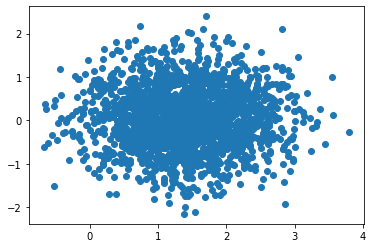

test samples: tensor([[ 0.7439,  0.6607],
        [ 1.8255, -1.1774],
        [ 1.4970,  1.2580],
        ...,
        [ 1.1416, -0.2143],
        [ 1.6064,  0.3595],
        [ 1.9173,  0.5629]])
auxil parameters: tensor([ 1.0000e+00,  1.0041e-04, -6.7682e-05,  1.0000e+00, -1.2160e-03,
         6.0891e-02], grad_fn=<CatBackward0>)
forward parameters: tensor([ 1.0000e+00,  1.0041e-04, -6.7682e-05,  1.0000e+00, -1.2160e-03,
         6.0891e-02], grad_fn=<CatBackward0>)
log det: tensor(1.8559e-05, grad_fn=<LogBackward0>)
forward parameters: tensor([ 1.0000e+00,  1.0041e-04, -6.7682e-05,  1.0000e+00, -1.2160e-03,
         6.0891e-02], grad_fn=<CatBackward0>)
log det: tensor(1.8559e-05, grad_fn=<LogBackward0>)
g1: (tensor([[124472.3994,    170.6569],
        [  4460.5825,  25009.5602]], grad_fn=<TBackward0>), tensor([70568.6762,  3168.9245], grad_fn=<ViewBackward0>))
initial residual
forward parameters: tensor([ 1.0000e+00,  1.0041e-04, -6.7682e-05,  1.0000e+00, -1.2160e-03,
         6.0891

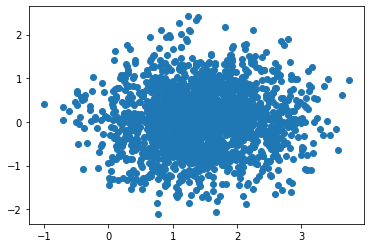

test samples: tensor([[ 2.4341, -0.6010],
        [ 2.8148, -1.2588],
        [ 0.6581, -0.0973],
        ...,
        [ 2.9238, -0.1509],
        [-0.0250,  0.7764],
        [ 1.6618,  0.7052]])
auxil parameters: tensor([ 1.0000e+00,  1.0078e-04, -6.4384e-05,  1.0000e+00, -1.2751e-03,
         6.2299e-02], grad_fn=<CatBackward0>)
forward parameters: tensor([ 1.0000e+00,  1.0078e-04, -6.4384e-05,  1.0000e+00, -1.2751e-03,
         6.2299e-02], grad_fn=<CatBackward0>)
log det: tensor(9.9906e-06, grad_fn=<LogBackward0>)
forward parameters: tensor([ 1.0000e+00,  1.0078e-04, -6.4384e-05,  1.0000e+00, -1.2751e-03,
         6.2299e-02], grad_fn=<CatBackward0>)
log det: tensor(9.9906e-06, grad_fn=<LogBackward0>)
g1: (tensor([[1.2546e+05, 4.6126e+01],
        [4.4498e+03, 2.5230e+04]], grad_fn=<TBackward0>), tensor([70793.1006,  3096.9079], grad_fn=<ViewBackward0>))
initial residual
forward parameters: tensor([ 1.0000e+00,  1.0078e-04, -6.4384e-05,  1.0000e+00, -1.2751e-03,
         6.2299e-02

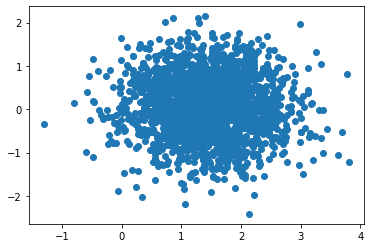

test samples: tensor([[ 2.4479,  0.4477],
        [ 1.2527, -0.2429],
        [ 1.9905, -0.1280],
        ...,
        [ 0.6721,  0.3215],
        [ 2.1796, -0.1493],
        [ 1.5195,  0.3467]])
auxil parameters: tensor([ 1.0000e+00,  1.0080e-04, -7.3908e-05,  1.0000e+00, -1.3364e-03,
         6.3726e-02], grad_fn=<CatBackward0>)
forward parameters: tensor([ 1.0000e+00,  1.0080e-04, -7.3908e-05,  1.0000e+00, -1.3364e-03,
         6.3726e-02], grad_fn=<CatBackward0>)
log det: tensor(1.0061e-05, grad_fn=<LogBackward0>)
forward parameters: tensor([ 1.0000e+00,  1.0080e-04, -7.3908e-05,  1.0000e+00, -1.3364e-03,
         6.3726e-02], grad_fn=<CatBackward0>)
log det: tensor(1.0061e-05, grad_fn=<LogBackward0>)
g1: (tensor([[1.2501e+05, 3.7254e+01],
        [4.5384e+03, 2.4988e+04]], grad_fn=<TBackward0>), tensor([70750.3996,  3179.7630], grad_fn=<ViewBackward0>))
initial residual
forward parameters: tensor([ 1.0000e+00,  1.0080e-04, -7.3908e-05,  1.0000e+00, -1.3364e-03,
         6.3726e-02

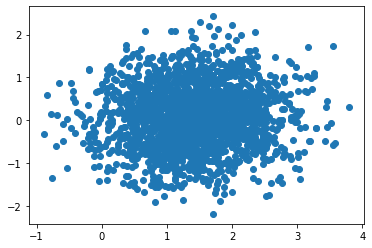

test samples: tensor([[ 1.5105,  0.5304],
        [ 0.8494,  0.1839],
        [ 1.1142,  0.5173],
        ...,
        [ 2.4507, -0.5274],
        [ 1.2333, -0.9103],
        [ 0.6605, -0.6184]])
auxil parameters: tensor([ 1.0000e+00,  1.0085e-04, -8.1300e-05,  1.0000e+00, -1.3990e-03,
         6.5149e-02], grad_fn=<CatBackward0>)
forward parameters: tensor([ 1.0000e+00,  1.0085e-04, -8.1300e-05,  1.0000e+00, -1.3990e-03,
         6.5149e-02], grad_fn=<CatBackward0>)
log det: tensor(9.3306e-06, grad_fn=<LogBackward0>)
forward parameters: tensor([ 1.0000e+00,  1.0085e-04, -8.1300e-05,  1.0000e+00, -1.3990e-03,
         6.5149e-02], grad_fn=<CatBackward0>)
log det: tensor(9.3306e-06, grad_fn=<LogBackward0>)
g1: (tensor([[ 1.2482e+05, -1.1212e+02],
        [ 4.4779e+03,  2.5136e+04]], grad_fn=<TBackward0>), tensor([70577.8463,  3301.1534], grad_fn=<ViewBackward0>))
initial residual
forward parameters: tensor([ 1.0000e+00,  1.0085e-04, -8.1300e-05,  1.0000e+00, -1.3990e-03,
         6.5149

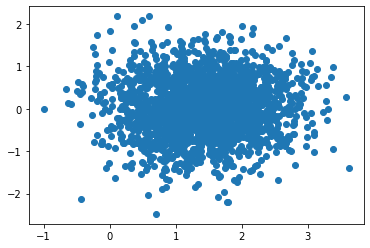

test samples: tensor([[ 2.2629, -0.5996],
        [ 2.6666, -0.0619],
        [ 1.0020, -0.1765],
        ...,
        [ 0.9556, -0.2875],
        [ 1.3921, -0.7609],
        [ 0.0992,  0.6761]])
auxil parameters: tensor([ 1.0000e+00,  1.0103e-04, -7.9097e-05,  1.0000e+00, -1.4624e-03,
         6.6558e-02], grad_fn=<CatBackward0>)
forward parameters: tensor([ 1.0000e+00,  1.0103e-04, -7.9097e-05,  1.0000e+00, -1.4624e-03,
         6.6558e-02], grad_fn=<CatBackward0>)
log det: tensor(5.3270e-06, grad_fn=<LogBackward0>)
forward parameters: tensor([ 1.0000e+00,  1.0103e-04, -7.9097e-05,  1.0000e+00, -1.4624e-03,
         6.6558e-02], grad_fn=<CatBackward0>)
log det: tensor(5.3270e-06, grad_fn=<LogBackward0>)
g1: (tensor([[125169.9400,    191.4864],
        [  4892.3798,  24971.8222]], grad_fn=<TBackward0>), tensor([70739.5237,  3417.1168], grad_fn=<ViewBackward0>))
initial residual
forward parameters: tensor([ 1.0000e+00,  1.0103e-04, -7.9097e-05,  1.0000e+00, -1.4624e-03,
         6.6558

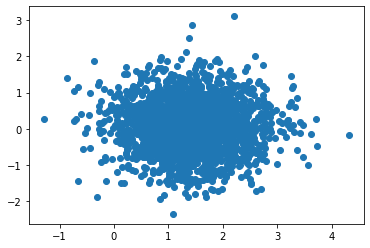

test samples: tensor([[ 0.7300, -0.6997],
        [ 1.6871, -0.8968],
        [ 0.6083,  0.9318],
        ...,
        [ 1.8255,  0.3481],
        [ 0.5241,  0.1962],
        [ 0.7950, -0.6049]])
auxil parameters: tensor([ 1.0000e+00,  1.0132e-04, -8.6163e-05,  1.0000e+00, -1.5278e-03,
         6.7981e-02], grad_fn=<CatBackward0>)
forward parameters: tensor([ 1.0000e+00,  1.0132e-04, -8.6163e-05,  1.0000e+00, -1.5278e-03,
         6.7981e-02], grad_fn=<CatBackward0>)
log det: tensor(-8.4139e-07, grad_fn=<LogBackward0>)
forward parameters: tensor([ 1.0000e+00,  1.0132e-04, -8.6163e-05,  1.0000e+00, -1.5278e-03,
         6.7981e-02], grad_fn=<CatBackward0>)
log det: tensor(-8.4139e-07, grad_fn=<LogBackward0>)
g1: (tensor([[124809.0489,    135.6786],
        [  4926.8114,  24934.3349]], grad_fn=<TBackward0>), tensor([70593.5514,  3522.1755], grad_fn=<ViewBackward0>))
initial residual
forward parameters: tensor([ 1.0000e+00,  1.0132e-04, -8.6163e-05,  1.0000e+00, -1.5278e-03,
         6.79

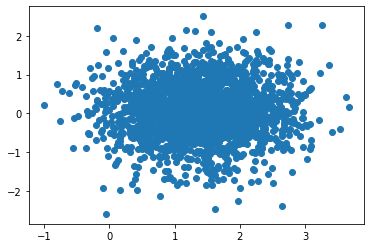

test samples: tensor([[ 1.1871,  1.3907],
        [ 1.1769,  0.9986],
        [ 1.6786, -1.0865],
        ...,
        [ 1.7422, -0.2722],
        [ 2.3426,  0.1424],
        [ 1.8564, -1.1668]])
auxil parameters: tensor([ 1.0000e+00,  1.0172e-04, -8.5192e-05,  9.9999e-01, -1.5941e-03,
         6.9392e-02], grad_fn=<CatBackward0>)
forward parameters: tensor([ 1.0000e+00,  1.0172e-04, -8.5192e-05,  9.9999e-01, -1.5941e-03,
         6.9392e-02], grad_fn=<CatBackward0>)
log det: tensor(-9.3628e-06, grad_fn=<LogBackward0>)
forward parameters: tensor([ 1.0000e+00,  1.0172e-04, -8.5192e-05,  9.9999e-01, -1.5941e-03,
         6.9392e-02], grad_fn=<CatBackward0>)
log det: tensor(-9.3628e-06, grad_fn=<LogBackward0>)
g1: (tensor([[ 1.2514e+05, -1.0044e+02],
        [ 4.7977e+03,  2.5136e+04]], grad_fn=<TBackward0>), tensor([70696.2947,  3493.3378], grad_fn=<ViewBackward0>))
initial residual
forward parameters: tensor([ 1.0000e+00,  1.0172e-04, -8.5192e-05,  9.9999e-01, -1.5941e-03,
         6.93

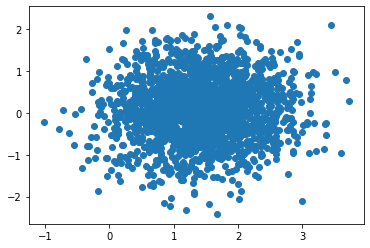

test samples: tensor([[ 2.0965, -1.1033],
        [ 1.4754,  1.7434],
        [ 1.1762, -0.0989],
        ...,
        [ 0.5014, -0.1819],
        [ 1.8333, -1.0800],
        [ 1.4180, -1.3151]])
auxil parameters: tensor([ 1.0000e+00,  1.0184e-04, -9.0200e-05,  9.9999e-01, -1.6622e-03,
         7.0812e-02], grad_fn=<CatBackward0>)
forward parameters: tensor([ 1.0000e+00,  1.0184e-04, -9.0200e-05,  9.9999e-01, -1.6622e-03,
         7.0812e-02], grad_fn=<CatBackward0>)
log det: tensor(-1.1968e-05, grad_fn=<LogBackward0>)
forward parameters: tensor([ 1.0000e+00,  1.0184e-04, -9.0200e-05,  9.9999e-01, -1.6622e-03,
         7.0812e-02], grad_fn=<CatBackward0>)
log det: tensor(-1.1968e-05, grad_fn=<LogBackward0>)
g1: (tensor([[125291.8175,    346.4790],
        [  5351.7717,  24725.7942]], grad_fn=<TBackward0>), tensor([70792.3510,  3711.7664], grad_fn=<ViewBackward0>))
initial residual
forward parameters: tensor([ 1.0000e+00,  1.0184e-04, -9.0200e-05,  9.9999e-01, -1.6622e-03,
         7.08

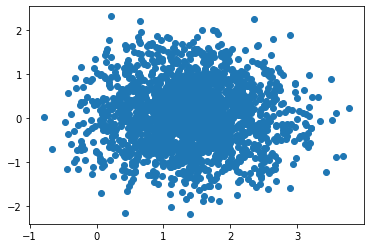

test samples: tensor([[ 0.9924,  0.1485],
        [ 0.5793, -0.4592],
        [ 1.5629, -0.0985],
        ...,
        [ 0.9250, -1.0271],
        [ 0.4772,  0.1365],
        [ 1.2067,  0.1213]])
auxil parameters: tensor([ 1.0000e+00,  1.0237e-04, -1.0080e-04,  9.9998e-01, -1.7321e-03,
         7.2239e-02], grad_fn=<CatBackward0>)
forward parameters: tensor([ 1.0000e+00,  1.0237e-04, -1.0080e-04,  9.9998e-01, -1.7321e-03,
         7.2239e-02], grad_fn=<CatBackward0>)
log det: tensor(-2.2724e-05, grad_fn=<LogBackward0>)
forward parameters: tensor([ 1.0000e+00,  1.0237e-04, -1.0080e-04,  9.9998e-01, -1.7321e-03,
         7.2239e-02], grad_fn=<CatBackward0>)
log det: tensor(-2.2724e-05, grad_fn=<LogBackward0>)
g1: (tensor([[125459.3537,   -147.6007],
        [  4962.4546,  24920.7086]], grad_fn=<TBackward0>), tensor([70864.5812,  3482.7093], grad_fn=<ViewBackward0>))
initial residual
forward parameters: tensor([ 1.0000e+00,  1.0237e-04, -1.0080e-04,  9.9998e-01, -1.7321e-03,
         7.22

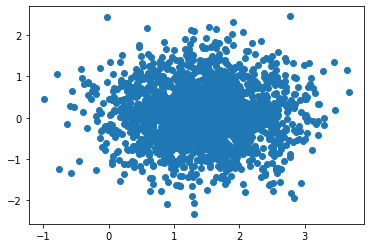

test samples: tensor([[ 1.9623,  0.6848],
        [ 2.0776,  0.7351],
        [ 1.5734,  1.2832],
        ...,
        [ 1.7014, -0.3507],
        [ 0.4629, -0.5633],
        [ 2.0071, -0.1130]])
auxil parameters: tensor([ 1.0000e+00,  1.0205e-04, -1.1577e-04,  9.9998e-01, -1.8037e-03,
         7.3673e-02], grad_fn=<CatBackward0>)
forward parameters: tensor([ 1.0000e+00,  1.0205e-04, -1.1577e-04,  9.9998e-01, -1.8037e-03,
         7.3673e-02], grad_fn=<CatBackward0>)
log det: tensor(-1.6213e-05, grad_fn=<LogBackward0>)
forward parameters: tensor([ 1.0000e+00,  1.0205e-04, -1.1577e-04,  9.9998e-01, -1.8037e-03,
         7.3673e-02], grad_fn=<CatBackward0>)
log det: tensor(-1.6213e-05, grad_fn=<LogBackward0>)
g1: (tensor([[ 1.2538e+05, -7.1317e+01],
        [ 5.1321e+03,  2.4795e+04]], grad_fn=<TBackward0>), tensor([70770.1191,  3639.9797], grad_fn=<ViewBackward0>))
initial residual
forward parameters: tensor([ 1.0000e+00,  1.0205e-04, -1.1577e-04,  9.9998e-01, -1.8037e-03,
         7.36

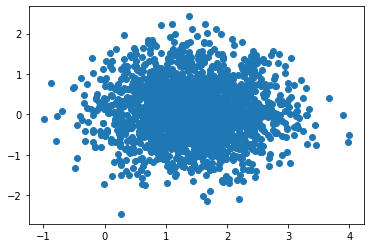

test samples: tensor([[ 2.0158, -0.4456],
        [ 2.4386, -0.9627],
        [-0.2431, -0.2410],
        ...,
        [ 1.8078, -0.0437],
        [ 0.7116,  0.0651],
        [ 2.2302,  0.6902]])
auxil parameters: tensor([ 1.0000e+00,  1.0198e-04, -1.2550e-04,  9.9998e-01, -1.8764e-03,
         7.5099e-02], grad_fn=<CatBackward0>)
forward parameters: tensor([ 1.0000e+00,  1.0198e-04, -1.2550e-04,  9.9998e-01, -1.8764e-03,
         7.5099e-02], grad_fn=<CatBackward0>)
log det: tensor(-1.4894e-05, grad_fn=<LogBackward0>)
forward parameters: tensor([ 1.0000e+00,  1.0198e-04, -1.2550e-04,  9.9998e-01, -1.8764e-03,
         7.5099e-02], grad_fn=<CatBackward0>)
log det: tensor(-1.4894e-05, grad_fn=<LogBackward0>)
g1: (tensor([[124687.4152,   -179.5149],
        [  5114.0917,  25136.9219]], grad_fn=<TBackward0>), tensor([70641.9441,  3556.6418], grad_fn=<ViewBackward0>))
initial residual
forward parameters: tensor([ 1.0000e+00,  1.0198e-04, -1.2550e-04,  9.9998e-01, -1.8764e-03,
         7.50

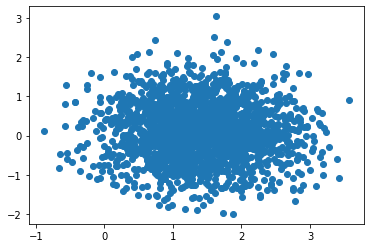

test samples: tensor([[ 1.9163, -0.5757],
        [ 2.2400, -0.5568],
        [ 2.7049, -1.3576],
        ...,
        [ 1.2730,  0.1839],
        [ 1.4471,  0.6164],
        [ 2.1753,  0.5994]])
auxil parameters: tensor([ 1.0000e+00,  1.0146e-04, -1.2829e-04,  9.9999e-01, -1.9499e-03,
         7.6515e-02], grad_fn=<CatBackward0>)
forward parameters: tensor([ 1.0000e+00,  1.0146e-04, -1.2829e-04,  9.9999e-01, -1.9499e-03,
         7.6515e-02], grad_fn=<CatBackward0>)
log det: tensor(-5.2884e-06, grad_fn=<LogBackward0>)
forward parameters: tensor([ 1.0000e+00,  1.0146e-04, -1.2829e-04,  9.9999e-01, -1.9499e-03,
         7.6515e-02], grad_fn=<CatBackward0>)
log det: tensor(-5.2884e-06, grad_fn=<LogBackward0>)
g1: (tensor([[1.2412e+05, 6.7379e+01],
        [5.4377e+03, 2.4849e+04]], grad_fn=<TBackward0>), tensor([70327.9269,  3882.7235], grad_fn=<ViewBackward0>))
initial residual
forward parameters: tensor([ 1.0000e+00,  1.0146e-04, -1.2829e-04,  9.9999e-01, -1.9499e-03,
         7.6515e-

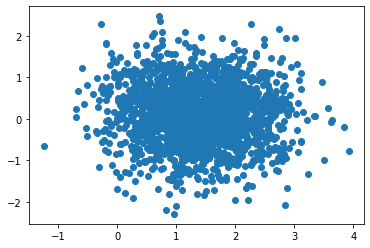

test samples: tensor([[ 0.9103, -0.1249],
        [ 1.4173, -0.6468],
        [ 1.3930, -0.6806],
        ...,
        [ 0.3773,  0.6125],
        [ 1.0670,  0.1683],
        [ 1.3848, -0.3004]])
auxil parameters: tensor([ 1.0000e+00,  1.0171e-04, -1.1353e-04,  9.9999e-01, -2.0236e-03,
         7.7907e-02], grad_fn=<CatBackward0>)
forward parameters: tensor([ 1.0000e+00,  1.0171e-04, -1.1353e-04,  9.9999e-01, -2.0236e-03,
         7.7907e-02], grad_fn=<CatBackward0>)
log det: tensor(-1.1008e-05, grad_fn=<LogBackward0>)
forward parameters: tensor([ 1.0000e+00,  1.0171e-04, -1.1353e-04,  9.9999e-01, -2.0236e-03,
         7.7907e-02], grad_fn=<CatBackward0>)
log det: tensor(-1.1008e-05, grad_fn=<LogBackward0>)
g1: (tensor([[123917.5307,   -177.2094],
        [  5289.4340,  24954.4984]], grad_fn=<TBackward0>), tensor([70283.1584,  3816.5509], grad_fn=<ViewBackward0>))
initial residual
forward parameters: tensor([ 1.0000e+00,  1.0171e-04, -1.1353e-04,  9.9999e-01, -2.0236e-03,
         7.79

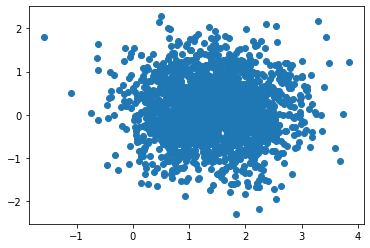

test samples: tensor([[ 1.6039, -0.6523],
        [ 0.8601, -0.3216],
        [ 0.8424,  0.6207],
        ...,
        [ 1.8036, -1.6875],
        [ 1.0394,  0.9960],
        [ 1.4656,  1.0255]])
auxil parameters: tensor([ 1.0000e+00,  1.0153e-04, -9.6386e-05,  9.9999e-01, -2.0985e-03,
         7.9295e-02], grad_fn=<CatBackward0>)
forward parameters: tensor([ 1.0000e+00,  1.0153e-04, -9.6386e-05,  9.9999e-01, -2.0985e-03,
         7.9295e-02], grad_fn=<CatBackward0>)
log det: tensor(-9.0570e-06, grad_fn=<LogBackward0>)
forward parameters: tensor([ 1.0000e+00,  1.0153e-04, -9.6386e-05,  9.9999e-01, -2.0985e-03,
         7.9295e-02], grad_fn=<CatBackward0>)
log det: tensor(-9.0570e-06, grad_fn=<LogBackward0>)
g1: (tensor([[125561.4920,   -368.2828],
        [  5240.2353,  25046.2835]], grad_fn=<TBackward0>), tensor([70814.4328,  3791.0902], grad_fn=<ViewBackward0>))
initial residual
forward parameters: tensor([ 1.0000e+00,  1.0153e-04, -9.6386e-05,  9.9999e-01, -2.0985e-03,
         7.92

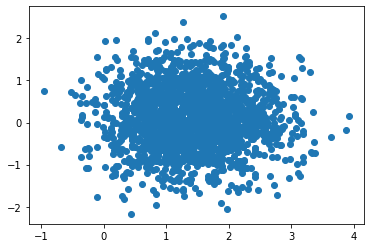

test samples: tensor([[ 1.5136, -0.6948],
        [ 1.5240, -0.1546],
        [ 1.3846, -0.4217],
        ...,
        [ 1.3747,  1.0421],
        [ 2.0232, -0.4781],
        [ 1.4001, -0.3760]])
auxil parameters: tensor([ 1.0000e+00,  1.0106e-04, -1.0938e-04,  1.0000e+00, -2.1771e-03,
         8.0725e-02], grad_fn=<CatBackward0>)
forward parameters: tensor([ 1.0000e+00,  1.0106e-04, -1.0938e-04,  1.0000e+00, -2.1771e-03,
         8.0725e-02], grad_fn=<CatBackward0>)
log det: tensor(-1.6980e-07, grad_fn=<LogBackward0>)
forward parameters: tensor([ 1.0000e+00,  1.0106e-04, -1.0938e-04,  1.0000e+00, -2.1771e-03,
         8.0725e-02], grad_fn=<CatBackward0>)
log det: tensor(-1.6980e-07, grad_fn=<LogBackward0>)
g1: (tensor([[124668.8503,   -258.6749],
        [  5423.0900,  24848.3600]], grad_fn=<TBackward0>), tensor([70476.6460,  3988.4179], grad_fn=<ViewBackward0>))
initial residual
forward parameters: tensor([ 1.0000e+00,  1.0106e-04, -1.0938e-04,  1.0000e+00, -2.1771e-03,
         8.07

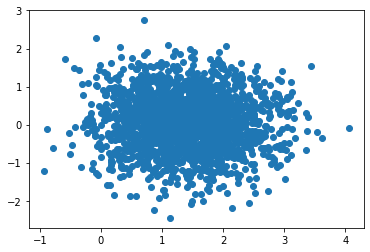

test samples: tensor([[ 1.5428,  1.3589],
        [ 0.0095,  0.9172],
        [ 1.6146, -0.8038],
        ...,
        [ 1.1047,  0.0699],
        [ 1.3234,  0.6195],
        [ 1.1536,  0.2899]])
auxil parameters: tensor([ 1.0000e+00,  1.0099e-04, -1.0366e-04,  1.0000e+00, -2.2557e-03,
         8.2129e-02], grad_fn=<CatBackward0>)
forward parameters: tensor([ 1.0000e+00,  1.0099e-04, -1.0366e-04,  1.0000e+00, -2.2557e-03,
         8.2129e-02], grad_fn=<CatBackward0>)
log det: tensor(6.5476e-07, grad_fn=<LogBackward0>)
forward parameters: tensor([ 1.0000e+00,  1.0099e-04, -1.0366e-04,  1.0000e+00, -2.2557e-03,
         8.2129e-02], grad_fn=<CatBackward0>)
log det: tensor(6.5476e-07, grad_fn=<LogBackward0>)
g1: (tensor([[ 1.2549e+05, -1.3673e+01],
        [ 5.8039e+03,  2.5130e+04]], grad_fn=<TBackward0>), tensor([70916.5111,  3910.9850], grad_fn=<ViewBackward0>))
initial residual
forward parameters: tensor([ 1.0000e+00,  1.0099e-04, -1.0366e-04,  1.0000e+00, -2.2557e-03,
         8.2129

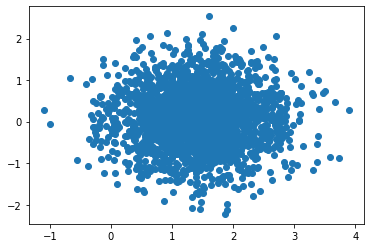

test samples: tensor([[ 1.5937, -0.1751],
        [ 2.2184,  0.0084],
        [ 1.8841, -0.1373],
        ...,
        [ 0.2962,  1.0531],
        [ 0.7377, -1.2117],
        [ 1.8262,  0.4015]])
auxil parameters: tensor([ 1.0000e+00,  1.0044e-04, -1.2326e-04,  1.0000e+00, -2.3378e-03,
         8.3569e-02], grad_fn=<CatBackward0>)
forward parameters: tensor([ 1.0000e+00,  1.0044e-04, -1.2326e-04,  1.0000e+00, -2.3378e-03,
         8.3569e-02], grad_fn=<CatBackward0>)
log det: tensor(1.1369e-05, grad_fn=<LogBackward0>)
forward parameters: tensor([ 1.0000e+00,  1.0044e-04, -1.2326e-04,  1.0000e+00, -2.3378e-03,
         8.3569e-02], grad_fn=<CatBackward0>)
log det: tensor(1.1369e-05, grad_fn=<LogBackward0>)
g1: (tensor([[125242.4871,    552.6626],
        [  6446.4695,  25088.9991]], grad_fn=<TBackward0>), tensor([70615.8082,  4491.7826], grad_fn=<ViewBackward0>))
initial residual
forward parameters: tensor([ 1.0000e+00,  1.0044e-04, -1.2326e-04,  1.0000e+00, -2.3378e-03,
         8.3569

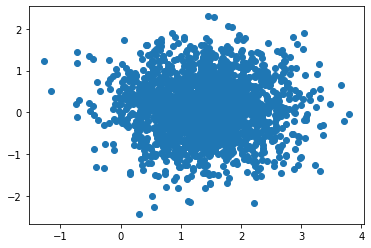

test samples: tensor([[ 0.9934,  0.5069],
        [ 1.7208,  0.2922],
        [ 1.4127,  0.9015],
        ...,
        [ 0.7094, -0.6406],
        [ 1.6214, -0.5955],
        [ 0.6884, -0.4069]])
auxil parameters: tensor([ 1.0000e+00,  1.0156e-04, -1.2570e-04,  9.9999e-01, -2.4198e-03,
         8.4984e-02], grad_fn=<CatBackward0>)
forward parameters: tensor([ 1.0000e+00,  1.0156e-04, -1.2570e-04,  9.9999e-01, -2.4198e-03,
         8.4984e-02], grad_fn=<CatBackward0>)
log det: tensor(-7.8062e-06, grad_fn=<LogBackward0>)
forward parameters: tensor([ 1.0000e+00,  1.0156e-04, -1.2570e-04,  9.9999e-01, -2.4198e-03,
         8.4984e-02], grad_fn=<CatBackward0>)
log det: tensor(-7.8062e-06, grad_fn=<LogBackward0>)
g1: (tensor([[1.2448e+05, 1.0609e+02],
        [6.0792e+03, 2.5013e+04]], grad_fn=<TBackward0>), tensor([70376.8961,  4309.0842], grad_fn=<ViewBackward0>))
initial residual
forward parameters: tensor([ 1.0000e+00,  1.0156e-04, -1.2570e-04,  9.9999e-01, -2.4198e-03,
         8.4984e-

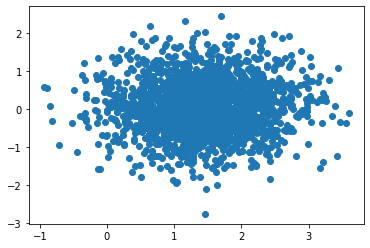

test samples: tensor([[ 1.4340,  0.0301],
        [ 1.1454,  0.0471],
        [ 2.1169, -0.1581],
        ...,
        [ 1.8958, -1.1029],
        [ 0.3716, -0.9041],
        [ 1.9225,  0.1063]])
auxil parameters: tensor([ 1.0000e+00,  1.0184e-04, -1.1510e-04,  9.9999e-01, -2.5022e-03,
         8.6381e-02], grad_fn=<CatBackward0>)
forward parameters: tensor([ 1.0000e+00,  1.0184e-04, -1.1510e-04,  9.9999e-01, -2.5022e-03,
         8.6381e-02], grad_fn=<CatBackward0>)
log det: tensor(-1.3507e-05, grad_fn=<LogBackward0>)
forward parameters: tensor([ 1.0000e+00,  1.0184e-04, -1.1510e-04,  9.9999e-01, -2.5022e-03,
         8.6381e-02], grad_fn=<CatBackward0>)
log det: tensor(-1.3507e-05, grad_fn=<LogBackward0>)
g1: (tensor([[ 1.2466e+05, -6.8283e+00],
        [ 6.0767e+03,  2.4749e+04]], grad_fn=<TBackward0>), tensor([70495.3947,  4374.9282], grad_fn=<ViewBackward0>))
initial residual
forward parameters: tensor([ 1.0000e+00,  1.0184e-04, -1.1510e-04,  9.9999e-01, -2.5022e-03,
         8.63

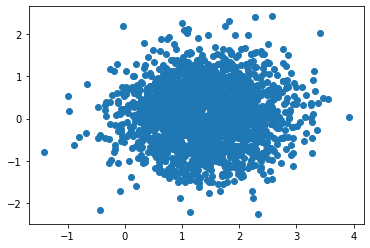

test samples: tensor([[ 1.9630,  0.3967],
        [ 1.2030,  0.1499],
        [-0.2930, -0.6073],
        ...,
        [ 0.8806, -1.2485],
        [ 0.4151, -0.4429],
        [ 1.0103, -0.6810]])
auxil parameters: tensor([ 1.0000e+00,  1.0211e-04, -1.1136e-04,  9.9998e-01, -2.5865e-03,
         8.7787e-02], grad_fn=<CatBackward0>)
forward parameters: tensor([ 1.0000e+00,  1.0211e-04, -1.1136e-04,  9.9998e-01, -2.5865e-03,
         8.7787e-02], grad_fn=<CatBackward0>)
log det: tensor(-1.8561e-05, grad_fn=<LogBackward0>)
forward parameters: tensor([ 1.0000e+00,  1.0211e-04, -1.1136e-04,  9.9998e-01, -2.5865e-03,
         8.7787e-02], grad_fn=<CatBackward0>)
log det: tensor(-1.8561e-05, grad_fn=<LogBackward0>)
g1: (tensor([[125014.3154,   -500.4483],
        [  5701.4852,  25123.1740]], grad_fn=<TBackward0>), tensor([70716.5324,  4031.2297], grad_fn=<ViewBackward0>))
initial residual
forward parameters: tensor([ 1.0000e+00,  1.0211e-04, -1.1136e-04,  9.9998e-01, -2.5865e-03,
         8.77

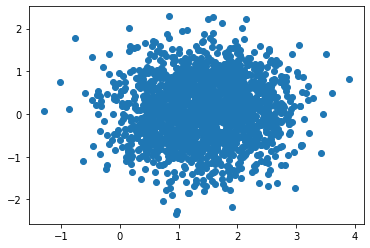

test samples: tensor([[ 1.5917, -0.6521],
        [ 1.5139,  0.8075],
        [ 2.8505,  0.4896],
        ...,
        [ 2.5437, -0.1601],
        [ 1.7538,  0.6246],
        [ 1.8043,  1.0529]])
auxil parameters: tensor([ 1.0000e+00,  1.0095e-04, -1.2037e-04,  1.0000e+00, -2.6734e-03,
         8.9211e-02], grad_fn=<CatBackward0>)
forward parameters: tensor([ 1.0000e+00,  1.0095e-04, -1.2037e-04,  1.0000e+00, -2.6734e-03,
         8.9211e-02], grad_fn=<CatBackward0>)
log det: tensor(4.7150e-07, grad_fn=<LogBackward0>)
forward parameters: tensor([ 1.0000e+00,  1.0095e-04, -1.2037e-04,  1.0000e+00, -2.6734e-03,
         8.9211e-02], grad_fn=<CatBackward0>)
log det: tensor(4.7150e-07, grad_fn=<LogBackward0>)
g1: (tensor([[1.2526e+05, 3.5456e+00],
        [6.3073e+03, 2.4767e+04]], grad_fn=<TBackward0>), tensor([70726.1833,  4390.6988], grad_fn=<ViewBackward0>))
initial residual
forward parameters: tensor([ 1.0000e+00,  1.0095e-04, -1.2037e-04,  1.0000e+00, -2.6734e-03,
         8.9211e-02

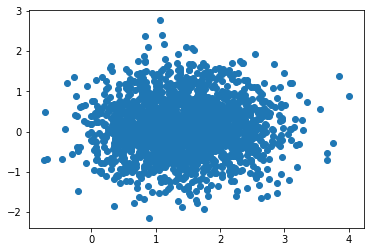

test samples: tensor([[ 1.3138,  0.2246],
        [ 2.0279, -0.8290],
        [ 1.8941, -0.8767],
        ...,
        [ 1.1679, -0.7628],
        [ 1.2343, -0.0672],
        [ 1.0390, -0.2228]])
auxil parameters: tensor([ 1.0000e+00,  1.0080e-04, -1.3010e-04,  1.0000e+00, -2.7617e-03,
         9.0636e-02], grad_fn=<CatBackward0>)
forward parameters: tensor([ 1.0000e+00,  1.0080e-04, -1.3010e-04,  1.0000e+00, -2.7617e-03,
         9.0636e-02], grad_fn=<CatBackward0>)
log det: tensor(3.4118e-06, grad_fn=<LogBackward0>)
forward parameters: tensor([ 1.0000e+00,  1.0080e-04, -1.3010e-04,  1.0000e+00, -2.7617e-03,
         9.0636e-02], grad_fn=<CatBackward0>)
log det: tensor(3.4118e-06, grad_fn=<LogBackward0>)
g1: (tensor([[124777.7051,    148.4550],
        [  6547.9475,  24965.3002]], grad_fn=<TBackward0>), tensor([70672.3564,  4619.1289], grad_fn=<ViewBackward0>))
initial residual
forward parameters: tensor([ 1.0000e+00,  1.0080e-04, -1.3010e-04,  1.0000e+00, -2.7617e-03,
         9.0636

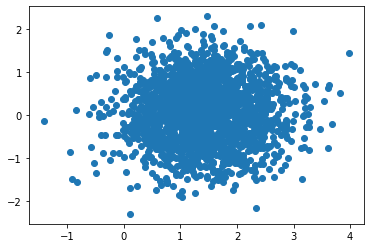

test samples: tensor([[ 1.6829,  0.9119],
        [-0.5691,  1.6982],
        [ 0.5310,  0.0760],
        ...,
        [ 1.4214,  1.1971],
        [ 1.5226,  0.3376],
        [ 2.6717, -0.1624]])
auxil parameters: tensor([ 1.0000e+00,  1.0121e-04, -1.3713e-04,  1.0000e+00, -2.8512e-03,
         9.2058e-02], grad_fn=<CatBackward0>)
forward parameters: tensor([ 1.0000e+00,  1.0121e-04, -1.3713e-04,  1.0000e+00, -2.8512e-03,
         9.2058e-02], grad_fn=<CatBackward0>)
log det: tensor(-2.7967e-06, grad_fn=<LogBackward0>)
forward parameters: tensor([ 1.0000e+00,  1.0121e-04, -1.3713e-04,  1.0000e+00, -2.8512e-03,
         9.2058e-02], grad_fn=<CatBackward0>)
log det: tensor(-2.7967e-06, grad_fn=<LogBackward0>)
g1: (tensor([[124054.3183,    361.9432],
        [  6829.6627,  24750.2831]], grad_fn=<TBackward0>), tensor([70322.7537,  4732.4488], grad_fn=<ViewBackward0>))
initial residual
forward parameters: tensor([ 1.0000e+00,  1.0121e-04, -1.3713e-04,  1.0000e+00, -2.8512e-03,
         9.20

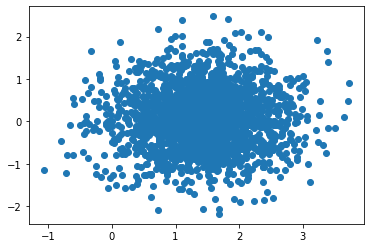

test samples: tensor([[ 1.5307,  0.7248],
        [ 1.4201,  0.3823],
        [ 2.1139,  0.4340],
        ...,
        [-0.4454, -0.1461],
        [ 1.1539, -0.4505],
        [ 0.9015,  0.2168]])
auxil parameters: tensor([ 1.0000e+00,  1.0178e-04, -1.2450e-04,  9.9999e-01, -2.9404e-03,
         9.3451e-02], grad_fn=<CatBackward0>)
forward parameters: tensor([ 1.0000e+00,  1.0178e-04, -1.2450e-04,  9.9999e-01, -2.9404e-03,
         9.3451e-02], grad_fn=<CatBackward0>)
log det: tensor(-1.2846e-05, grad_fn=<LogBackward0>)
forward parameters: tensor([ 1.0000e+00,  1.0178e-04, -1.2450e-04,  9.9999e-01, -2.9404e-03,
         9.3451e-02], grad_fn=<CatBackward0>)
log det: tensor(-1.2846e-05, grad_fn=<LogBackward0>)
g1: (tensor([[124578.4131,    213.9623],
        [  6802.0439,  25117.2591]], grad_fn=<TBackward0>), tensor([70536.8069,  4899.7769], grad_fn=<ViewBackward0>))
initial residual
forward parameters: tensor([ 1.0000e+00,  1.0178e-04, -1.2450e-04,  9.9999e-01, -2.9404e-03,
         9.34

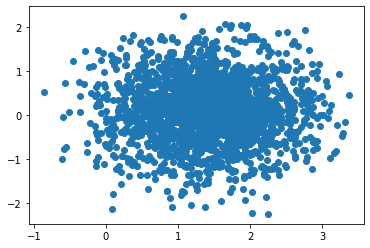

test samples: tensor([[ 2.8085,  0.8332],
        [ 1.3856,  0.6843],
        [ 1.7338,  1.8952],
        ...,
        [ 0.1415,  0.7213],
        [ 1.8625, -0.5475],
        [ 1.6272,  0.2245]])
auxil parameters: tensor([ 1.0000e+00,  1.0270e-04, -1.2437e-04,  9.9997e-01, -3.0321e-03,
         9.4862e-02], grad_fn=<CatBackward0>)
forward parameters: tensor([ 1.0000e+00,  1.0270e-04, -1.2437e-04,  9.9997e-01, -3.0321e-03,
         9.4862e-02], grad_fn=<CatBackward0>)
log det: tensor(-2.7312e-05, grad_fn=<LogBackward0>)
forward parameters: tensor([ 1.0000e+00,  1.0270e-04, -1.2437e-04,  9.9997e-01, -3.0321e-03,
         9.4862e-02], grad_fn=<CatBackward0>)
log det: tensor(-2.7312e-05, grad_fn=<LogBackward0>)
g1: (tensor([[1.2495e+05, 2.1366e+01],
        [6.7185e+03, 2.4968e+04]], grad_fn=<TBackward0>), tensor([70637.4587,  4766.5409], grad_fn=<ViewBackward0>))
initial residual
forward parameters: tensor([ 1.0000e+00,  1.0270e-04, -1.2437e-04,  9.9997e-01, -3.0321e-03,
         9.4862e-

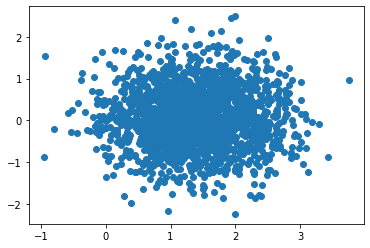

test samples: tensor([[ 1.1386, -0.8550],
        [ 1.0985,  0.0371],
        [ 1.6055, -0.1505],
        ...,
        [ 1.8520, -0.6413],
        [ 1.6920,  0.9664],
        [ 0.8026,  0.3381]])
auxil parameters: tensor([ 1.0000e+00,  1.0286e-04, -1.3012e-04,  9.9997e-01, -3.1257e-03,
         9.6281e-02], grad_fn=<CatBackward0>)
forward parameters: tensor([ 1.0000e+00,  1.0286e-04, -1.3012e-04,  9.9997e-01, -3.1257e-03,
         9.6281e-02], grad_fn=<CatBackward0>)
log det: tensor(-2.9951e-05, grad_fn=<LogBackward0>)
forward parameters: tensor([ 1.0000e+00,  1.0286e-04, -1.3012e-04,  9.9997e-01, -3.1257e-03,
         9.6281e-02], grad_fn=<CatBackward0>)
log det: tensor(-2.9951e-05, grad_fn=<LogBackward0>)
g1: (tensor([[1.2434e+05, 5.9152e+01],
        [6.8355e+03, 2.4959e+04]], grad_fn=<TBackward0>), tensor([70418.5004,  4841.2232], grad_fn=<ViewBackward0>))
initial residual
forward parameters: tensor([ 1.0000e+00,  1.0286e-04, -1.3012e-04,  9.9997e-01, -3.1257e-03,
         9.6281e-

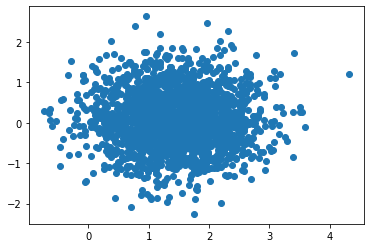

test samples: tensor([[ 0.8860, -0.3543],
        [ 0.9064, -0.8799],
        [ 1.1714,  0.5403],
        ...,
        [ 1.8852, -0.4736],
        [ 0.8193, -0.7486],
        [ 2.9728,  0.1038]])
auxil parameters: tensor([ 1.0000e+00,  1.0304e-04, -1.2375e-04,  9.9997e-01, -3.2197e-03,
         9.7683e-02], grad_fn=<CatBackward0>)
forward parameters: tensor([ 1.0000e+00,  1.0304e-04, -1.2375e-04,  9.9997e-01, -3.2197e-03,
         9.7683e-02], grad_fn=<CatBackward0>)
log det: tensor(-3.3633e-05, grad_fn=<LogBackward0>)
forward parameters: tensor([ 1.0000e+00,  1.0304e-04, -1.2375e-04,  9.9997e-01, -3.2197e-03,
         9.7683e-02], grad_fn=<CatBackward0>)
log det: tensor(-3.3633e-05, grad_fn=<LogBackward0>)
g1: (tensor([[1.2498e+05, 1.9979e+01],
        [6.9230e+03, 2.5000e+04]], grad_fn=<TBackward0>), tensor([70693.9356,  4814.4459], grad_fn=<ViewBackward0>))
initial residual
forward parameters: tensor([ 1.0000e+00,  1.0304e-04, -1.2375e-04,  9.9997e-01, -3.2197e-03,
         9.7683e-

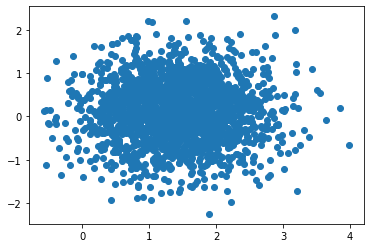

test samples: tensor([[ 2.4290, -0.0919],
        [ 0.9618, -1.0591],
        [ 1.2549, -0.3731],
        ...,
        [ 1.7306,  0.4321],
        [ 1.0263, -0.0896],
        [ 1.1082, -0.1755]])
auxil parameters: tensor([ 1.0000e+00,  1.0284e-04, -1.3329e-04,  9.9997e-01, -3.3165e-03,
         9.9107e-02], grad_fn=<CatBackward0>)
forward parameters: tensor([ 1.0000e+00,  1.0284e-04, -1.3329e-04,  9.9997e-01, -3.3165e-03,
         9.9107e-02], grad_fn=<CatBackward0>)
log det: tensor(-3.0693e-05, grad_fn=<LogBackward0>)
forward parameters: tensor([ 1.0000e+00,  1.0284e-04, -1.3329e-04,  9.9997e-01, -3.3165e-03,
         9.9107e-02], grad_fn=<CatBackward0>)
log det: tensor(-3.0693e-05, grad_fn=<LogBackward0>)
g1: (tensor([[124204.0705,   -172.5822],
        [  6803.4330,  24938.1430]], grad_fn=<TBackward0>), tensor([70416.2334,  4930.4589], grad_fn=<ViewBackward0>))
initial residual
forward parameters: tensor([ 1.0000e+00,  1.0284e-04, -1.3329e-04,  9.9997e-01, -3.3165e-03,
         9.91

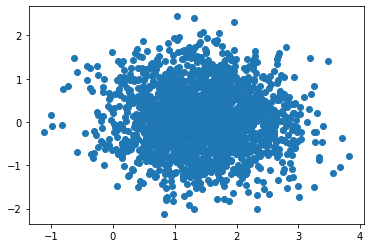

test samples: tensor([[ 1.7994, -0.1921],
        [ 1.1414,  0.6500],
        [ 0.4525, -0.8333],
        ...,
        [ 0.9537, -0.5604],
        [ 1.8951, -1.2998],
        [ 0.5498, -0.5053]])
auxil parameters: tensor([ 1.0000e+00,  1.0282e-04, -1.2730e-04,  9.9997e-01, -3.4133e-03,
         1.0051e-01], grad_fn=<CatBackward0>)
forward parameters: tensor([ 1.0000e+00,  1.0282e-04, -1.2730e-04,  9.9997e-01, -3.4133e-03,
         1.0051e-01], grad_fn=<CatBackward0>)
log det: tensor(-3.1395e-05, grad_fn=<LogBackward0>)
forward parameters: tensor([ 1.0000e+00,  1.0282e-04, -1.2730e-04,  9.9997e-01, -3.4133e-03,
         1.0051e-01], grad_fn=<CatBackward0>)
log det: tensor(-3.1395e-05, grad_fn=<LogBackward0>)
g1: (tensor([[124149.8443,   -159.0241],
        [  6917.5304,  25158.8306]], grad_fn=<TBackward0>), tensor([70419.9556,  4993.1281], grad_fn=<ViewBackward0>))
initial residual
forward parameters: tensor([ 1.0000e+00,  1.0282e-04, -1.2730e-04,  9.9997e-01, -3.4133e-03,
         1.00

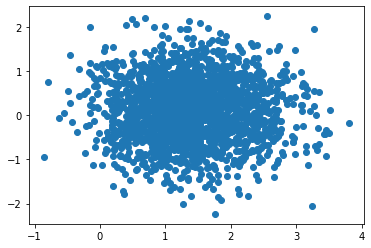

test samples: tensor([[ 1.4280, -0.9579],
        [ 1.7889, -0.5129],
        [-0.4187, -0.7539],
        ...,
        [ 0.4411,  0.9193],
        [ 0.6424, -0.0715],
        [ 1.0205,  0.2636]])
auxil parameters: tensor([ 1.0000e+00,  1.0277e-04, -1.2178e-04,  9.9997e-01, -3.5115e-03,
         1.0191e-01], grad_fn=<CatBackward0>)
forward parameters: tensor([ 1.0000e+00,  1.0277e-04, -1.2178e-04,  9.9997e-01, -3.5115e-03,
         1.0191e-01], grad_fn=<CatBackward0>)
log det: tensor(-3.1631e-05, grad_fn=<LogBackward0>)
forward parameters: tensor([ 1.0000e+00,  1.0277e-04, -1.2178e-04,  9.9997e-01, -3.5115e-03,
         1.0191e-01], grad_fn=<CatBackward0>)
log det: tensor(-3.1631e-05, grad_fn=<LogBackward0>)
g1: (tensor([[ 1.2418e+05, -3.3540e+01],
        [ 7.1490e+03,  2.4837e+04]], grad_fn=<TBackward0>), tensor([70478.6028,  5007.0100], grad_fn=<ViewBackward0>))
initial residual
forward parameters: tensor([ 1.0000e+00,  1.0277e-04, -1.2178e-04,  9.9997e-01, -3.5115e-03,
         1.01

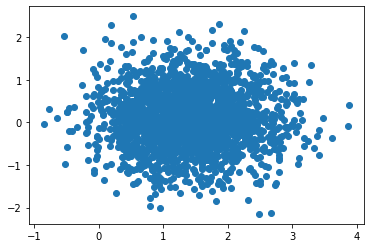

test samples: tensor([[ 0.2487,  0.9520],
        [ 0.9155, -1.0695],
        [ 1.4628, -0.8109],
        ...,
        [ 2.1552, -0.4538],
        [ 2.3100, -0.9764],
        [ 2.0056, -0.5770]])
auxil parameters: tensor([ 1.0000e+00,  1.0249e-04, -1.1989e-04,  9.9997e-01, -3.6115e-03,
         1.0332e-01], grad_fn=<CatBackward0>)
forward parameters: tensor([ 1.0000e+00,  1.0249e-04, -1.1989e-04,  9.9997e-01, -3.6115e-03,
         1.0332e-01], grad_fn=<CatBackward0>)
log det: tensor(-2.8423e-05, grad_fn=<LogBackward0>)
forward parameters: tensor([ 1.0000e+00,  1.0249e-04, -1.1989e-04,  9.9997e-01, -3.6115e-03,
         1.0332e-01], grad_fn=<CatBackward0>)
log det: tensor(-2.8423e-05, grad_fn=<LogBackward0>)
g1: (tensor([[124988.8865,   -163.3300],
        [  7133.2957,  25108.0025]], grad_fn=<TBackward0>), tensor([70614.6648,  5048.1010], grad_fn=<ViewBackward0>))
initial residual
forward parameters: tensor([ 1.0000e+00,  1.0249e-04, -1.1989e-04,  9.9997e-01, -3.6115e-03,
         1.03

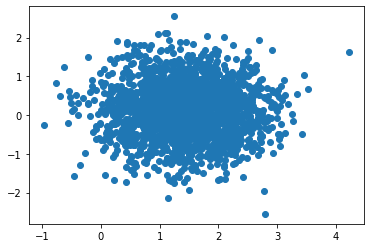

test samples: tensor([[ 1.5987,  0.0305],
        [ 1.2865,  0.2346],
        [ 2.2676,  0.3107],
        ...,
        [ 0.9219,  0.5778],
        [ 1.3394,  0.1194],
        [ 1.3052, -0.7465]])
auxil parameters: tensor([ 1.0000e+00,  1.0209e-04, -1.2597e-04,  9.9998e-01, -3.7137e-03,
         1.0474e-01], grad_fn=<CatBackward0>)
forward parameters: tensor([ 1.0000e+00,  1.0209e-04, -1.2597e-04,  9.9998e-01, -3.7137e-03,
         1.0474e-01], grad_fn=<CatBackward0>)
log det: tensor(-2.3020e-05, grad_fn=<LogBackward0>)
forward parameters: tensor([ 1.0000e+00,  1.0209e-04, -1.2597e-04,  9.9998e-01, -3.7137e-03,
         1.0474e-01], grad_fn=<CatBackward0>)
log det: tensor(-2.3020e-05, grad_fn=<LogBackward0>)
g1: (tensor([[1.2394e+05, 1.1874e+02],
        [7.4771e+03, 2.4768e+04]], grad_fn=<TBackward0>), tensor([70238.3269,  5326.3244], grad_fn=<ViewBackward0>))
initial residual
forward parameters: tensor([ 1.0000e+00,  1.0209e-04, -1.2597e-04,  9.9998e-01, -3.7137e-03,
         1.0474e-

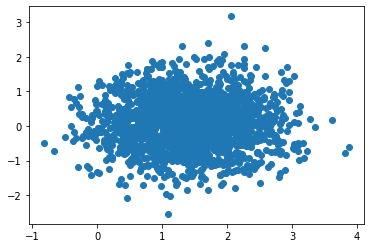

test samples: tensor([[ 0.8209,  0.2613],
        [ 1.6789,  0.3429],
        [ 0.4848,  0.3502],
        ...,
        [ 1.8490,  0.5965],
        [ 0.7994,  0.9841],
        [ 1.9837, -0.5058]])
auxil parameters: tensor([ 1.0000e+00,  1.0255e-04, -1.1113e-04,  9.9997e-01, -3.8151e-03,
         1.0613e-01], grad_fn=<CatBackward0>)
forward parameters: tensor([ 1.0000e+00,  1.0255e-04, -1.1113e-04,  9.9997e-01, -3.8151e-03,
         1.0613e-01], grad_fn=<CatBackward0>)
log det: tensor(-3.0889e-05, grad_fn=<LogBackward0>)
forward parameters: tensor([ 1.0000e+00,  1.0255e-04, -1.1113e-04,  9.9997e-01, -3.8151e-03,
         1.0613e-01], grad_fn=<CatBackward0>)
log det: tensor(-3.0889e-05, grad_fn=<LogBackward0>)
g1: (tensor([[124848.0068,    313.7788],
        [  7798.8454,  25034.4065]], grad_fn=<TBackward0>), tensor([70491.6440,  5320.5871], grad_fn=<ViewBackward0>))
initial residual
forward parameters: tensor([ 1.0000e+00,  1.0255e-04, -1.1113e-04,  9.9997e-01, -3.8151e-03,
         1.06

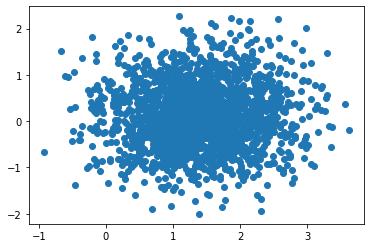

test samples: tensor([[ 2.5584,  0.3404],
        [ 1.1504,  0.6378],
        [ 1.5553,  0.7425],
        ...,
        [ 2.4396,  0.0242],
        [ 0.7158, -0.4950],
        [ 0.6849,  0.0381]])
auxil parameters: tensor([ 1.0000e+00,  1.0269e-04, -1.1083e-04,  9.9997e-01, -3.9195e-03,
         1.0754e-01], grad_fn=<CatBackward0>)
forward parameters: tensor([ 1.0000e+00,  1.0269e-04, -1.1083e-04,  9.9997e-01, -3.9195e-03,
         1.0754e-01], grad_fn=<CatBackward0>)
log det: tensor(-3.3326e-05, grad_fn=<LogBackward0>)
forward parameters: tensor([ 1.0000e+00,  1.0269e-04, -1.1083e-04,  9.9997e-01, -3.9195e-03,
         1.0754e-01], grad_fn=<CatBackward0>)
log det: tensor(-3.3326e-05, grad_fn=<LogBackward0>)
g1: (tensor([[124961.5677,   -226.6993],
        [  7368.5728,  24987.6945]], grad_fn=<TBackward0>), tensor([70590.3054,  5223.7670], grad_fn=<ViewBackward0>))
initial residual
forward parameters: tensor([ 1.0000e+00,  1.0269e-04, -1.1083e-04,  9.9997e-01, -3.9195e-03,
         1.07

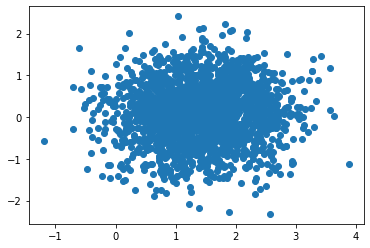

test samples: tensor([[ 1.4398, -0.9639],
        [ 1.0829,  0.6101],
        [ 1.6996, -1.2855],
        ...,
        [ 1.4134,  0.4903],
        [ 1.8904, -0.5636],
        [ 1.8353, -0.0342]])
auxil parameters: tensor([ 1.0000e+00,  1.0212e-04, -1.1640e-04,  9.9998e-01, -4.0260e-03,
         1.0896e-01], grad_fn=<CatBackward0>)
forward parameters: tensor([ 1.0000e+00,  1.0212e-04, -1.1640e-04,  9.9998e-01, -4.0260e-03,
         1.0896e-01], grad_fn=<CatBackward0>)
log det: tensor(-2.5891e-05, grad_fn=<LogBackward0>)
forward parameters: tensor([ 1.0000e+00,  1.0212e-04, -1.1640e-04,  9.9998e-01, -4.0260e-03,
         1.0896e-01], grad_fn=<CatBackward0>)
log det: tensor(-2.5891e-05, grad_fn=<LogBackward0>)
g1: (tensor([[1.2460e+05, 3.8271e+01],
        [7.7111e+03, 2.4943e+04]], grad_fn=<TBackward0>), tensor([70377.7333,  5410.0305], grad_fn=<ViewBackward0>))
initial residual
forward parameters: tensor([ 1.0000e+00,  1.0212e-04, -1.1640e-04,  9.9998e-01, -4.0260e-03,
         1.0896e-

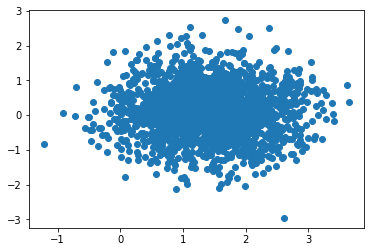

test samples: tensor([[ 0.5281, -1.2621],
        [ 1.5448, -0.4339],
        [ 0.8528, -0.1212],
        ...,
        [ 2.7130, -0.5908],
        [ 1.8695, -0.1180],
        [ 1.5456, -0.0901]])
auxil parameters: tensor([ 1.0000e+00,  1.0205e-04, -1.1036e-04,  9.9998e-01, -4.1325e-03,
         1.1036e-01], grad_fn=<CatBackward0>)
forward parameters: tensor([ 1.0000e+00,  1.0205e-04, -1.1036e-04,  9.9998e-01, -4.1325e-03,
         1.1036e-01], grad_fn=<CatBackward0>)
log det: tensor(-2.5878e-05, grad_fn=<LogBackward0>)
forward parameters: tensor([ 1.0000e+00,  1.0205e-04, -1.1036e-04,  9.9998e-01, -4.1325e-03,
         1.1036e-01], grad_fn=<CatBackward0>)
log det: tensor(-2.5878e-05, grad_fn=<LogBackward0>)
g1: (tensor([[125001.4856,    607.9012],
        [  8405.3416,  25069.1008]], grad_fn=<TBackward0>), tensor([70582.9689,  5899.4747], grad_fn=<ViewBackward0>))
initial residual
forward parameters: tensor([ 1.0000e+00,  1.0205e-04, -1.1036e-04,  9.9998e-01, -4.1325e-03,
         1.10

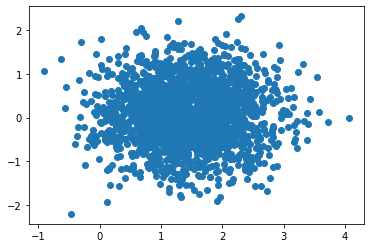

test samples: tensor([[ 2.8334, -0.3728],
        [ 2.2507,  0.6074],
        [ 2.3799, -0.3881],
        ...,
        [ 0.6982, -1.2864],
        [ 0.8804,  0.5459],
        [ 1.0088, -1.1123]])
auxil parameters: tensor([ 1.0000e+00,  1.0380e-04, -1.1606e-04,  9.9995e-01, -4.2418e-03,
         1.1178e-01], grad_fn=<CatBackward0>)
forward parameters: tensor([ 1.0000e+00,  1.0380e-04, -1.1606e-04,  9.9995e-01, -4.2418e-03,
         1.1178e-01], grad_fn=<CatBackward0>)
log det: tensor(-4.8536e-05, grad_fn=<LogBackward0>)
forward parameters: tensor([ 1.0000e+00,  1.0380e-04, -1.1606e-04,  9.9995e-01, -4.2418e-03,
         1.1178e-01], grad_fn=<CatBackward0>)
log det: tensor(-4.8536e-05, grad_fn=<LogBackward0>)
g1: (tensor([[1.2456e+05, 2.3308e+01],
        [7.8942e+03, 2.4874e+04]], grad_fn=<TBackward0>), tensor([70355.7979,  5619.9984], grad_fn=<ViewBackward0>))
initial residual
forward parameters: tensor([ 1.0000e+00,  1.0380e-04, -1.1606e-04,  9.9995e-01, -4.2418e-03,
         1.1178e-

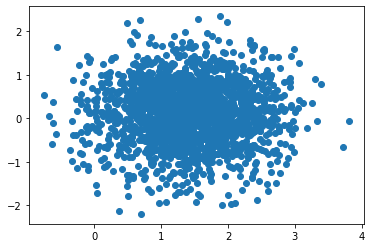

test samples: tensor([[ 2.4978,  0.5777],
        [ 1.9093, -0.0918],
        [ 1.4595,  0.0130],
        ...,
        [ 0.1302, -1.3435],
        [ 0.7963, -0.4089],
        [ 0.6409, -0.1058]])
auxil parameters: tensor([ 1.0000e+00,  1.0401e-04, -1.0940e-04,  9.9995e-01, -4.3511e-03,
         1.1318e-01], grad_fn=<CatBackward0>)
forward parameters: tensor([ 1.0000e+00,  1.0401e-04, -1.0940e-04,  9.9995e-01, -4.3511e-03,
         1.1318e-01], grad_fn=<CatBackward0>)
log det: tensor(-5.2465e-05, grad_fn=<LogBackward0>)
forward parameters: tensor([ 1.0000e+00,  1.0401e-04, -1.0940e-04,  9.9995e-01, -4.3511e-03,
         1.1318e-01], grad_fn=<CatBackward0>)
log det: tensor(-5.2465e-05, grad_fn=<LogBackward0>)
g1: (tensor([[125117.7836,   -214.0292],
        [  7787.3126,  24944.1712]], grad_fn=<TBackward0>), tensor([70630.0951,  5495.9718], grad_fn=<ViewBackward0>))
initial residual
forward parameters: tensor([ 1.0000e+00,  1.0401e-04, -1.0940e-04,  9.9995e-01, -4.3511e-03,
         1.13

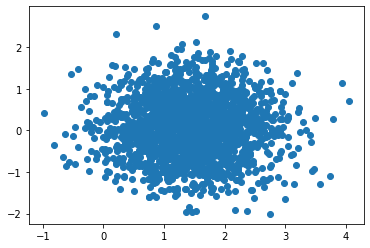

test samples: tensor([[ 0.6202,  0.3924],
        [ 2.0190, -0.2953],
        [ 1.5830, -0.3355],
        ...,
        [ 0.2965, -0.6758],
        [ 1.5381, -0.4940],
        [ 0.8726, -0.6527]])
auxil parameters: tensor([ 1.0000e+00,  1.0335e-04, -1.1843e-04,  9.9996e-01, -4.4636e-03,
         1.1460e-01], grad_fn=<CatBackward0>)
forward parameters: tensor([ 1.0000e+00,  1.0335e-04, -1.1843e-04,  9.9996e-01, -4.4636e-03,
         1.1460e-01], grad_fn=<CatBackward0>)
log det: tensor(-4.4163e-05, grad_fn=<LogBackward0>)
forward parameters: tensor([ 1.0000e+00,  1.0335e-04, -1.1843e-04,  9.9996e-01, -4.4636e-03,
         1.1460e-01], grad_fn=<CatBackward0>)
log det: tensor(-4.4163e-05, grad_fn=<LogBackward0>)
g1: (tensor([[ 1.2502e+05, -2.0107e+01],
        [ 8.0704e+03,  2.5072e+04]], grad_fn=<TBackward0>), tensor([70528.8663,  5671.6579], grad_fn=<ViewBackward0>))
initial residual
forward parameters: tensor([ 1.0000e+00,  1.0335e-04, -1.1843e-04,  9.9996e-01, -4.4636e-03,
         1.14

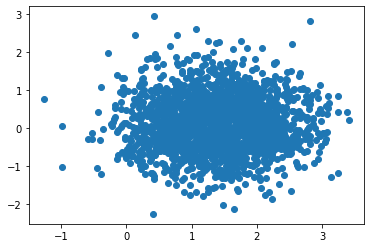

test samples: tensor([[ 1.4054, -0.7194],
        [ 0.8822,  0.4051],
        [ 1.6800,  0.4408],
        ...,
        [ 0.7434,  0.1615],
        [ 1.6169,  0.4464],
        [ 1.8337,  0.9286]])
auxil parameters: tensor([ 1.0000e+00,  1.0317e-04, -1.2206e-04,  9.9996e-01, -4.5769e-03,
         1.1601e-01], grad_fn=<CatBackward0>)
forward parameters: tensor([ 1.0000e+00,  1.0317e-04, -1.2206e-04,  9.9996e-01, -4.5769e-03,
         1.1601e-01], grad_fn=<CatBackward0>)
log det: tensor(-4.2236e-05, grad_fn=<LogBackward0>)
forward parameters: tensor([ 1.0000e+00,  1.0317e-04, -1.2206e-04,  9.9996e-01, -4.5769e-03,
         1.1601e-01], grad_fn=<CatBackward0>)
log det: tensor(-4.2236e-05, grad_fn=<LogBackward0>)
g1: (tensor([[ 1.2533e+05, -7.4644e+01],
        [ 8.1335e+03,  2.5284e+04]], grad_fn=<TBackward0>), tensor([70681.3751,  5689.7458], grad_fn=<ViewBackward0>))
initial residual
forward parameters: tensor([ 1.0000e+00,  1.0317e-04, -1.2206e-04,  9.9996e-01, -4.5769e-03,
         1.16

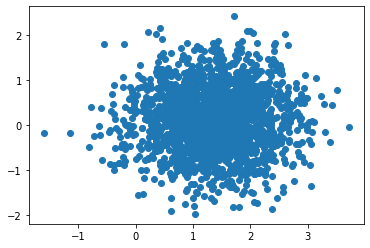

test samples: tensor([[ 1.6636,  0.5938],
        [ 1.2925, -1.0687],
        [ 1.5660, -0.7187],
        ...,
        [ 1.2471, -0.2344],
        [ 0.7758, -0.4835],
        [ 1.6755,  0.0866]])
auxil parameters: tensor([ 1.0000e+00,  1.0275e-04, -1.3459e-04,  9.9996e-01, -4.6926e-03,
         1.1744e-01], grad_fn=<CatBackward0>)
forward parameters: tensor([ 1.0000e+00,  1.0275e-04, -1.3459e-04,  9.9996e-01, -4.6926e-03,
         1.1744e-01], grad_fn=<CatBackward0>)
log det: tensor(-3.6656e-05, grad_fn=<LogBackward0>)
forward parameters: tensor([ 1.0000e+00,  1.0275e-04, -1.3459e-04,  9.9996e-01, -4.6926e-03,
         1.1744e-01], grad_fn=<CatBackward0>)
log det: tensor(-3.6656e-05, grad_fn=<LogBackward0>)
g1: (tensor([[1.2548e+05, 2.3579e+01],
        [8.3378e+03, 2.4899e+04]], grad_fn=<TBackward0>), tensor([70724.3664,  5906.8949], grad_fn=<ViewBackward0>))
initial residual
forward parameters: tensor([ 1.0000e+00,  1.0275e-04, -1.3459e-04,  9.9996e-01, -4.6926e-03,
         1.1744e-

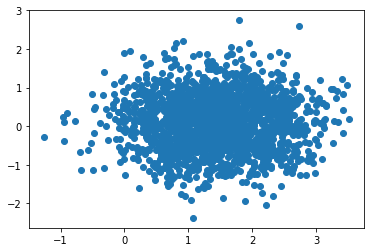

test samples: tensor([[ 0.5193,  0.7497],
        [ 1.4652, -0.2659],
        [ 1.1900,  0.0266],
        ...,
        [ 1.2535,  0.1526],
        [ 1.5805, -0.3568],
        [ 1.0408, -0.5673]])
auxil parameters: tensor([ 1.0000e+00,  1.0300e-04, -1.4985e-04,  9.9996e-01, -4.8101e-03,
         1.1887e-01], grad_fn=<CatBackward0>)
forward parameters: tensor([ 1.0000e+00,  1.0300e-04, -1.4985e-04,  9.9996e-01, -4.8101e-03,
         1.1887e-01], grad_fn=<CatBackward0>)
log det: tensor(-3.9141e-05, grad_fn=<LogBackward0>)
forward parameters: tensor([ 1.0000e+00,  1.0300e-04, -1.4985e-04,  9.9996e-01, -4.8101e-03,
         1.1887e-01], grad_fn=<CatBackward0>)
log det: tensor(-3.9141e-05, grad_fn=<LogBackward0>)
g1: (tensor([[124260.1527,    560.9799],
        [  8926.5951,  24827.9205]], grad_fn=<TBackward0>), tensor([70304.1505,  6158.3556], grad_fn=<ViewBackward0>))
initial residual
forward parameters: tensor([ 1.0000e+00,  1.0300e-04, -1.4985e-04,  9.9996e-01, -4.8101e-03,
         1.18

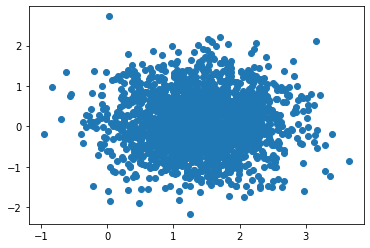

test samples: tensor([[ 1.5555e+00, -6.2775e-01],
        [ 6.0779e-01, -1.7374e-01],
        [ 1.0560e+00,  1.3745e-04],
        ...,
        [ 1.7689e+00,  7.2296e-01],
        [ 1.3180e+00, -8.7700e-01],
        [ 1.4026e+00,  5.3623e-01]])
auxil parameters: tensor([ 1.0000e+00,  1.0413e-04, -1.4169e-04,  9.9995e-01, -4.9262e-03,
         1.2027e-01], grad_fn=<CatBackward0>)
forward parameters: tensor([ 1.0000e+00,  1.0413e-04, -1.4169e-04,  9.9995e-01, -4.9262e-03,
         1.2027e-01], grad_fn=<CatBackward0>)
log det: tensor(-5.3925e-05, grad_fn=<LogBackward0>)
forward parameters: tensor([ 1.0000e+00,  1.0413e-04, -1.4169e-04,  9.9995e-01, -4.9262e-03,
         1.2027e-01], grad_fn=<CatBackward0>)
log det: tensor(-5.3925e-05, grad_fn=<LogBackward0>)
g1: (tensor([[124427.9081,   -176.7298],
        [  8302.1955,  24642.5015]], grad_fn=<TBackward0>), tensor([70427.5602,  5847.0357], grad_fn=<ViewBackward0>))
initial residual
forward parameters: tensor([ 1.0000e+00,  1.0413e-04, -1.4

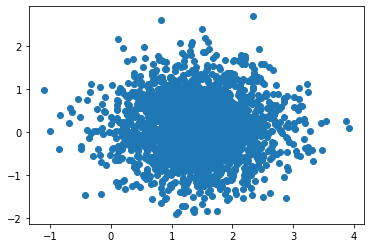

test samples: tensor([[ 1.3643,  0.1754],
        [ 1.8592, -0.0665],
        [ 0.8199,  0.1733],
        ...,
        [ 0.6724, -0.5651],
        [ 2.3915, -0.7372],
        [ 2.0360, -1.5559]])
auxil parameters: tensor([ 1.0000e+00,  1.0341e-04, -1.4094e-04,  9.9996e-01, -5.0446e-03,
         1.2168e-01], grad_fn=<CatBackward0>)
forward parameters: tensor([ 1.0000e+00,  1.0341e-04, -1.4094e-04,  9.9996e-01, -5.0446e-03,
         1.2168e-01], grad_fn=<CatBackward0>)
log det: tensor(-4.6271e-05, grad_fn=<LogBackward0>)
forward parameters: tensor([ 1.0000e+00,  1.0341e-04, -1.4094e-04,  9.9996e-01, -5.0446e-03,
         1.2168e-01], grad_fn=<CatBackward0>)
log det: tensor(-4.6271e-05, grad_fn=<LogBackward0>)
g1: (tensor([[124112.4362,   -349.5407],
        [  8219.9468,  25046.1662]], grad_fn=<TBackward0>), tensor([70346.7595,  5929.5469], grad_fn=<ViewBackward0>))
initial residual
forward parameters: tensor([ 1.0000e+00,  1.0341e-04, -1.4094e-04,  9.9996e-01, -5.0446e-03,
         1.21

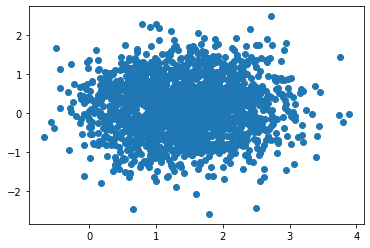

test samples: tensor([[ 1.5550,  0.6617],
        [ 0.4058, -1.5503],
        [ 1.6822,  0.1328],
        ...,
        [ 2.3019,  0.1006],
        [ 0.8284, -1.4963],
        [ 1.6915, -1.4904]])
auxil parameters: tensor([ 1.0000e+00,  1.0276e-04, -1.3587e-04,  9.9996e-01, -5.1639e-03,
         1.2308e-01], grad_fn=<CatBackward0>)
forward parameters: tensor([ 1.0000e+00,  1.0276e-04, -1.3587e-04,  9.9996e-01, -5.1639e-03,
         1.2308e-01], grad_fn=<CatBackward0>)
log det: tensor(-3.9758e-05, grad_fn=<LogBackward0>)
forward parameters: tensor([ 1.0000e+00,  1.0276e-04, -1.3587e-04,  9.9996e-01, -5.1639e-03,
         1.2308e-01], grad_fn=<CatBackward0>)
log det: tensor(-3.9758e-05, grad_fn=<LogBackward0>)
g1: (tensor([[1.2485e+05, 4.1340e+01],
        [8.7314e+03, 2.5150e+04]], grad_fn=<TBackward0>), tensor([70504.7792,  6180.8409], grad_fn=<ViewBackward0>))
initial residual
forward parameters: tensor([ 1.0000e+00,  1.0276e-04, -1.3587e-04,  9.9996e-01, -5.1639e-03,
         1.2308e-

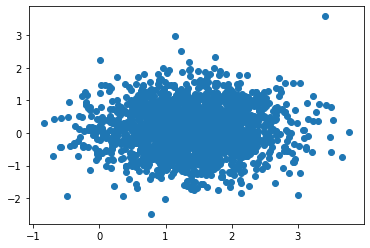

test samples: tensor([[ 1.4412,  0.6879],
        [ 1.7632,  0.3486],
        [ 0.9106, -0.3566],
        ...,
        [ 0.3996,  0.3563],
        [ 1.4180, -0.0692],
        [ 2.5522,  0.2637]])
auxil parameters: tensor([ 1.0000e+00,  1.0299e-04, -1.4013e-04,  9.9996e-01, -5.2857e-03,
         1.2449e-01], grad_fn=<CatBackward0>)
forward parameters: tensor([ 1.0000e+00,  1.0299e-04, -1.4013e-04,  9.9996e-01, -5.2857e-03,
         1.2449e-01], grad_fn=<CatBackward0>)
log det: tensor(-4.2627e-05, grad_fn=<LogBackward0>)
forward parameters: tensor([ 1.0000e+00,  1.0299e-04, -1.4013e-04,  9.9996e-01, -5.2857e-03,
         1.2449e-01], grad_fn=<CatBackward0>)
log det: tensor(-4.2627e-05, grad_fn=<LogBackward0>)
g1: (tensor([[1.2556e+05, 6.3817e+00],
        [8.8344e+03, 2.4806e+04]], grad_fn=<TBackward0>), tensor([70807.9653,  6239.1426], grad_fn=<ViewBackward0>))
initial residual
forward parameters: tensor([ 1.0000e+00,  1.0299e-04, -1.4013e-04,  9.9996e-01, -5.2857e-03,
         1.2449e-

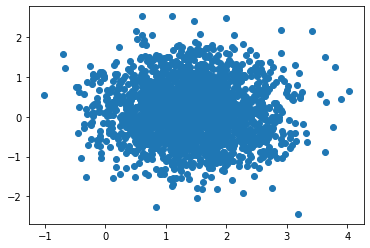

test samples: tensor([[ 0.4233,  0.1532],
        [ 1.5050, -1.0028],
        [-0.3339,  0.3192],
        ...,
        [-0.0143, -0.0891],
        [ 1.6297, -0.6133],
        [ 1.1190, -0.4452]])
auxil parameters: tensor([ 1.0000e+00,  1.0316e-04, -1.6190e-04,  9.9996e-01, -5.4111e-03,
         1.2593e-01], grad_fn=<CatBackward0>)
forward parameters: tensor([ 1.0000e+00,  1.0316e-04, -1.6190e-04,  9.9996e-01, -5.4111e-03,
         1.2593e-01], grad_fn=<CatBackward0>)
log det: tensor(-4.3349e-05, grad_fn=<LogBackward0>)
forward parameters: tensor([ 1.0000e+00,  1.0316e-04, -1.6190e-04,  9.9996e-01, -5.4111e-03,
         1.2593e-01], grad_fn=<CatBackward0>)
log det: tensor(-4.3349e-05, grad_fn=<LogBackward0>)
g1: (tensor([[ 1.2502e+05, -1.2839e+01],
        [ 8.8854e+03,  2.4995e+04]], grad_fn=<TBackward0>), tensor([70573.3842,  6182.3787], grad_fn=<ViewBackward0>))
initial residual
forward parameters: tensor([ 1.0000e+00,  1.0316e-04, -1.6190e-04,  9.9996e-01, -5.4111e-03,
         1.25

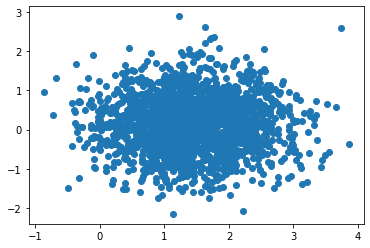

test samples: tensor([[ 1.6218,  0.8847],
        [ 1.5729, -0.8224],
        [ 0.9602, -0.6626],
        ...,
        [ 0.8735,  0.2125],
        [ 1.5589,  0.7062],
        [ 1.0795,  0.8206]])
auxil parameters: tensor([ 1.0000e+00,  1.0269e-04, -1.7073e-04,  9.9996e-01, -5.5363e-03,
         1.2736e-01], grad_fn=<CatBackward0>)
forward parameters: tensor([ 1.0000e+00,  1.0269e-04, -1.7073e-04,  9.9996e-01, -5.5363e-03,
         1.2736e-01], grad_fn=<CatBackward0>)
log det: tensor(-3.7952e-05, grad_fn=<LogBackward0>)
forward parameters: tensor([ 1.0000e+00,  1.0269e-04, -1.7073e-04,  9.9996e-01, -5.5363e-03,
         1.2736e-01], grad_fn=<CatBackward0>)
log det: tensor(-3.7952e-05, grad_fn=<LogBackward0>)
g1: (tensor([[125278.5129,   -262.8465],
        [  8742.3306,  25034.4737]], grad_fn=<TBackward0>), tensor([70629.7877,  6154.0026], grad_fn=<ViewBackward0>))
initial residual
forward parameters: tensor([ 1.0000e+00,  1.0269e-04, -1.7073e-04,  9.9996e-01, -5.5363e-03,
         1.27

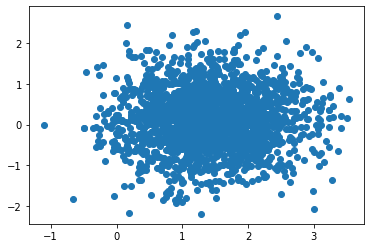

test samples: tensor([[ 0.2725,  0.4122],
        [ 1.5443, -0.4729],
        [ 1.8039, -0.2909],
        ...,
        [ 0.2519, -0.3088],
        [ 1.4527,  0.4073],
        [ 0.5020,  1.0341]])
auxil parameters: tensor([ 1.0000e+00,  1.0174e-04, -1.8303e-04,  9.9997e-01, -5.6633e-03,
         1.2878e-01], grad_fn=<CatBackward0>)
forward parameters: tensor([ 1.0000e+00,  1.0174e-04, -1.8303e-04,  9.9997e-01, -5.6633e-03,
         1.2878e-01], grad_fn=<CatBackward0>)
log det: tensor(-2.6738e-05, grad_fn=<LogBackward0>)
forward parameters: tensor([ 1.0000e+00,  1.0174e-04, -1.8303e-04,  9.9997e-01, -5.6633e-03,
         1.2878e-01], grad_fn=<CatBackward0>)
log det: tensor(-2.6738e-05, grad_fn=<LogBackward0>)
g1: (tensor([[1.2523e+05, 1.1384e+02],
        [9.2150e+03, 2.5062e+04]], grad_fn=<TBackward0>), tensor([70579.3942,  6591.0538], grad_fn=<ViewBackward0>))
initial residual
forward parameters: tensor([ 1.0000e+00,  1.0174e-04, -1.8303e-04,  9.9997e-01, -5.6633e-03,
         1.2878e-

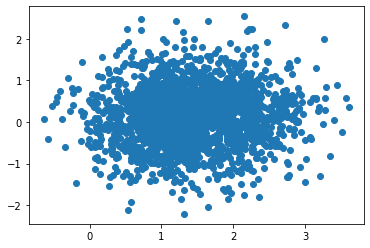

test samples: tensor([[ 1.2423,  0.2035],
        [ 0.9371,  0.6520],
        [ 1.8574, -0.2792],
        ...,
        [ 0.9979,  0.6017],
        [ 2.0260, -0.6679],
        [ 1.9696,  0.5376]])
auxil parameters: tensor([ 1.0000e+00,  1.0264e-04, -1.9286e-04,  9.9996e-01, -5.7915e-03,
         1.3020e-01], grad_fn=<CatBackward0>)
forward parameters: tensor([ 1.0000e+00,  1.0264e-04, -1.9286e-04,  9.9996e-01, -5.7915e-03,
         1.3020e-01], grad_fn=<CatBackward0>)
log det: tensor(-3.6416e-05, grad_fn=<LogBackward0>)
forward parameters: tensor([ 1.0000e+00,  1.0264e-04, -1.9286e-04,  9.9996e-01, -5.7915e-03,
         1.3020e-01], grad_fn=<CatBackward0>)
log det: tensor(-3.6416e-05, grad_fn=<LogBackward0>)
g1: (tensor([[1.2493e+05, 1.1986e+02],
        [9.3076e+03, 2.5277e+04]], grad_fn=<TBackward0>), tensor([70481.6774,  6475.7416], grad_fn=<ViewBackward0>))
initial residual
forward parameters: tensor([ 1.0000e+00,  1.0264e-04, -1.9286e-04,  9.9996e-01, -5.7915e-03,
         1.3020e-

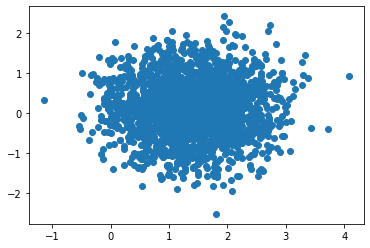

test samples: tensor([[ 1.0608, -0.2653],
        [ 0.7125,  0.8855],
        [ 1.6022, -0.3075],
        ...,
        [ 0.7733,  1.9370],
        [ 1.1758, -0.0873],
        [ 1.4060, -0.2903]])
auxil parameters: tensor([ 1.0000e+00,  1.0259e-04, -1.9755e-04,  9.9996e-01, -5.9204e-03,
         1.3162e-01], grad_fn=<CatBackward0>)
forward parameters: tensor([ 1.0000e+00,  1.0259e-04, -1.9755e-04,  9.9996e-01, -5.9204e-03,
         1.3162e-01], grad_fn=<CatBackward0>)
log det: tensor(-3.6044e-05, grad_fn=<LogBackward0>)
forward parameters: tensor([ 1.0000e+00,  1.0259e-04, -1.9755e-04,  9.9996e-01, -5.9204e-03,
         1.3162e-01], grad_fn=<CatBackward0>)
log det: tensor(-3.6044e-05, grad_fn=<LogBackward0>)
g1: (tensor([[123715.6905,   -561.8778],
        [  8670.9227,  25090.5796]], grad_fn=<TBackward0>), tensor([70074.7775,  6199.6367], grad_fn=<ViewBackward0>))
initial residual
forward parameters: tensor([ 1.0000e+00,  1.0259e-04, -1.9755e-04,  9.9996e-01, -5.9204e-03,
         1.31

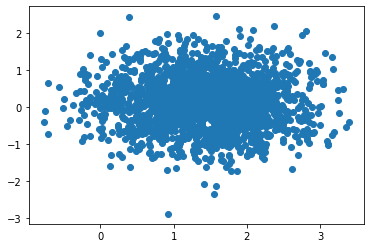

test samples: tensor([[ 1.2518, -0.3553],
        [ 1.0032, -0.3917],
        [ 0.9064,  0.2227],
        ...,
        [ 0.9909, -1.8223],
        [ 1.4306, -0.9177],
        [ 0.9587, -0.5086]])
auxil parameters: tensor([ 1.0000e+00,  1.0075e-04, -1.7973e-04,  9.9998e-01, -6.0477e-03,
         1.3300e-01], grad_fn=<CatBackward0>)
forward parameters: tensor([ 1.0000e+00,  1.0075e-04, -1.7973e-04,  9.9998e-01, -6.0477e-03,
         1.3300e-01], grad_fn=<CatBackward0>)
log det: tensor(-1.8327e-05, grad_fn=<LogBackward0>)
forward parameters: tensor([ 1.0000e+00,  1.0075e-04, -1.7973e-04,  9.9998e-01, -6.0477e-03,
         1.3300e-01], grad_fn=<CatBackward0>)
log det: tensor(-1.8327e-05, grad_fn=<LogBackward0>)
g1: (tensor([[124858.7703,    248.1048],
        [  9632.7716,  24902.5022]], grad_fn=<TBackward0>), tensor([70443.2526,  6711.2782], grad_fn=<ViewBackward0>))
initial residual
forward parameters: tensor([ 1.0000e+00,  1.0075e-04, -1.7973e-04,  9.9998e-01, -6.0477e-03,
         1.33

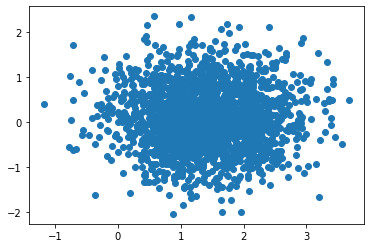

test samples: tensor([[ 1.2240, -0.7517],
        [ 2.2350, -0.7962],
        [ 2.1239,  0.7894],
        ...,
        [ 2.1531,  0.8569],
        [ 1.8610, -0.5033],
        [ 2.0830,  0.6293]])
auxil parameters: tensor([ 1.0000e+00,  1.0122e-04, -1.8296e-04,  9.9998e-01, -6.1793e-03,
         1.3441e-01], grad_fn=<CatBackward0>)
forward parameters: tensor([ 1.0000e+00,  1.0122e-04, -1.8296e-04,  9.9998e-01, -6.1793e-03,
         1.3441e-01], grad_fn=<CatBackward0>)
log det: tensor(-2.3430e-05, grad_fn=<LogBackward0>)
forward parameters: tensor([ 1.0000e+00,  1.0122e-04, -1.8296e-04,  9.9998e-01, -6.1793e-03,
         1.3441e-01], grad_fn=<CatBackward0>)
log det: tensor(-2.3430e-05, grad_fn=<LogBackward0>)
g1: (tensor([[124815.5769,   -189.8389],
        [  9291.9648,  24884.0357]], grad_fn=<TBackward0>), tensor([70433.3596,  6465.0402], grad_fn=<ViewBackward0>))
initial residual
forward parameters: tensor([ 1.0000e+00,  1.0122e-04, -1.8296e-04,  9.9998e-01, -6.1793e-03,
         1.34

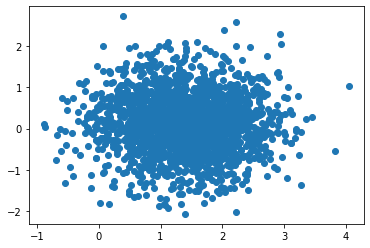

test samples: tensor([[ 0.9703,  0.1558],
        [ 1.0109,  0.4345],
        [ 0.1347, -0.6013],
        ...,
        [ 0.3591,  0.0903],
        [ 0.8329, -0.0263],
        [ 2.0693,  0.6649]])
auxil parameters: tensor([ 1.0000e+00,  9.9999e-05, -1.8610e-04,  9.9999e-01, -6.3122e-03,
         1.3583e-01], grad_fn=<CatBackward0>)
forward parameters: tensor([ 1.0000e+00,  9.9999e-05, -1.8610e-04,  9.9999e-01, -6.3122e-03,
         1.3583e-01], grad_fn=<CatBackward0>)
log det: tensor(-1.0645e-05, grad_fn=<LogBackward0>)
forward parameters: tensor([ 1.0000e+00,  9.9999e-05, -1.8610e-04,  9.9999e-01, -6.3122e-03,
         1.3583e-01], grad_fn=<CatBackward0>)
log det: tensor(-1.0645e-05, grad_fn=<LogBackward0>)
g1: (tensor([[124789.9526,   -175.5802],
        [  9408.2105,  24883.2774]], grad_fn=<TBackward0>), tensor([70443.1718,  6573.1460], grad_fn=<ViewBackward0>))
initial residual
forward parameters: tensor([ 1.0000e+00,  9.9999e-05, -1.8610e-04,  9.9999e-01, -6.3122e-03,
         1.35

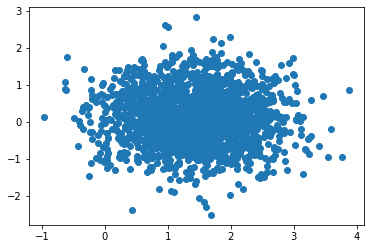

test samples: tensor([[ 0.1070, -0.8850],
        [ 0.4946,  1.0173],
        [ 2.0119, -0.1592],
        ...,
        [ 0.5129, -0.8622],
        [ 1.8304, -0.7353],
        [ 1.2731,  0.9240]])
auxil parameters: tensor([ 1.0000e+00,  9.8984e-05, -1.9015e-04,  1.0000e+00, -6.4467e-03,
         1.3724e-01], grad_fn=<CatBackward0>)
forward parameters: tensor([ 1.0000e+00,  9.8984e-05, -1.9015e-04,  1.0000e+00, -6.4467e-03,
         1.3724e-01], grad_fn=<CatBackward0>)
log det: tensor(9.6407e-08, grad_fn=<LogBackward0>)
forward parameters: tensor([ 1.0000e+00,  9.8984e-05, -1.9015e-04,  1.0000e+00, -6.4467e-03,
         1.3724e-01], grad_fn=<CatBackward0>)
log det: tensor(9.6407e-08, grad_fn=<LogBackward0>)
g1: (tensor([[124444.1093,    394.5318],
        [ 10089.9110,  25080.2458]], grad_fn=<TBackward0>), tensor([70504.2406,  7068.8351], grad_fn=<ViewBackward0>))
initial residual
forward parameters: tensor([ 1.0000e+00,  9.8984e-05, -1.9015e-04,  1.0000e+00, -6.4467e-03,
         1.3724

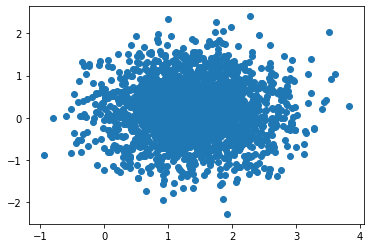

test samples: tensor([[ 2.2463, -2.0842],
        [ 1.6397,  1.1345],
        [ 1.0514,  0.4994],
        ...,
        [ 1.6979, -1.0268],
        [ 1.3964,  0.5302],
        [ 0.1549,  0.5641]])
auxil parameters: tensor([ 1.0000e+00,  1.0028e-04, -1.9807e-04,  9.9999e-01, -6.5831e-03,
         1.3866e-01], grad_fn=<CatBackward0>)
forward parameters: tensor([ 1.0000e+00,  1.0028e-04, -1.9807e-04,  9.9999e-01, -6.5831e-03,
         1.3866e-01], grad_fn=<CatBackward0>)
log det: tensor(-1.2742e-05, grad_fn=<LogBackward0>)
forward parameters: tensor([ 1.0000e+00,  1.0028e-04, -1.9807e-04,  9.9999e-01, -6.5831e-03,
         1.3866e-01], grad_fn=<CatBackward0>)
log det: tensor(-1.2742e-05, grad_fn=<LogBackward0>)
g1: (tensor([[124506.6121,    240.4589],
        [ 10017.6462,  24866.1956]], grad_fn=<TBackward0>), tensor([70377.6167,  6975.6792], grad_fn=<ViewBackward0>))
initial residual
forward parameters: tensor([ 1.0000e+00,  1.0028e-04, -1.9807e-04,  9.9999e-01, -6.5831e-03,
         1.38

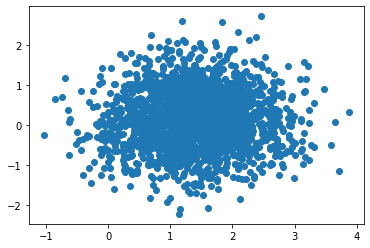

test samples: tensor([[ 1.1735, -0.0286],
        [ 1.3740, -0.2521],
        [ 1.4469, -0.7282],
        ...,
        [ 1.0134, -0.3667],
        [ 0.3455, -1.0954],
        [ 2.3780,  0.0434]])
auxil parameters: tensor([ 1.0000e+00,  1.0068e-04, -1.9913e-04,  9.9998e-01, -6.7200e-03,
         1.4007e-01], grad_fn=<CatBackward0>)
forward parameters: tensor([ 1.0000e+00,  1.0068e-04, -1.9913e-04,  9.9998e-01, -6.7200e-03,
         1.4007e-01], grad_fn=<CatBackward0>)
log det: tensor(-1.7107e-05, grad_fn=<LogBackward0>)
forward parameters: tensor([ 1.0000e+00,  1.0068e-04, -1.9913e-04,  9.9998e-01, -6.7200e-03,
         1.4007e-01], grad_fn=<CatBackward0>)
log det: tensor(-1.7107e-05, grad_fn=<LogBackward0>)
g1: (tensor([[124875.9066,    201.2571],
        [ 10079.4388,  25011.2560]], grad_fn=<TBackward0>), tensor([70375.9747,  7175.7711], grad_fn=<ViewBackward0>))
initial residual
forward parameters: tensor([ 1.0000e+00,  1.0068e-04, -1.9913e-04,  9.9998e-01, -6.7200e-03,
         1.40

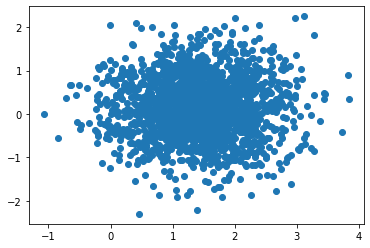

test samples: tensor([[ 1.4518, -0.2487],
        [ 2.1019, -0.0264],
        [-0.1949, -1.3077],
        ...,
        [ 1.3594,  0.4308],
        [ 1.4268,  0.3030],
        [ 1.1728,  0.2649]])
auxil parameters: tensor([ 1.0000e+00,  1.0180e-04, -2.0052e-04,  9.9997e-01, -6.8583e-03,
         1.4148e-01], grad_fn=<CatBackward0>)
forward parameters: tensor([ 1.0000e+00,  1.0180e-04, -2.0052e-04,  9.9997e-01, -6.8583e-03,
         1.4148e-01], grad_fn=<CatBackward0>)
log det: tensor(-2.8733e-05, grad_fn=<LogBackward0>)
forward parameters: tensor([ 1.0000e+00,  1.0180e-04, -2.0052e-04,  9.9997e-01, -6.8583e-03,
         1.4148e-01], grad_fn=<CatBackward0>)
log det: tensor(-2.8733e-05, grad_fn=<LogBackward0>)
g1: (tensor([[124612.8497,    205.5223],
        [ 10193.5811,  25230.7691]], grad_fn=<TBackward0>), tensor([70442.6747,  7240.3901], grad_fn=<ViewBackward0>))
initial residual
forward parameters: tensor([ 1.0000e+00,  1.0180e-04, -2.0052e-04,  9.9997e-01, -6.8583e-03,
         1.41

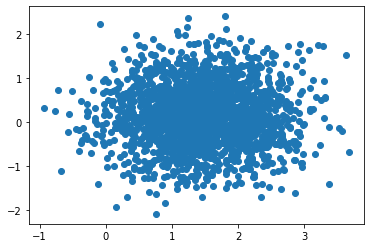

test samples: tensor([[ 1.2420,  0.3444],
        [ 1.6917, -0.8297],
        [ 2.3668,  0.5081],
        ...,
        [ 0.0954,  0.4148],
        [ 2.1320,  0.7184],
        [ 0.8019,  0.6270]])
auxil parameters: tensor([ 1.0000e+00,  1.0287e-04, -2.0608e-04,  9.9996e-01, -6.9986e-03,
         1.4289e-01], grad_fn=<CatBackward0>)
forward parameters: tensor([ 1.0000e+00,  1.0287e-04, -2.0608e-04,  9.9996e-01, -6.9986e-03,
         1.4289e-01], grad_fn=<CatBackward0>)
log det: tensor(-3.9534e-05, grad_fn=<LogBackward0>)
forward parameters: tensor([ 1.0000e+00,  1.0287e-04, -2.0608e-04,  9.9996e-01, -6.9986e-03,
         1.4289e-01], grad_fn=<CatBackward0>)
log det: tensor(-3.9534e-05, grad_fn=<LogBackward0>)
g1: (tensor([[ 1.2515e+05, -2.9669e+01],
        [ 1.0066e+04,  2.5224e+04]], grad_fn=<TBackward0>), tensor([70501.0467,  7167.2874], grad_fn=<ViewBackward0>))
initial residual
forward parameters: tensor([ 1.0000e+00,  1.0287e-04, -2.0608e-04,  9.9996e-01, -6.9986e-03,
         1.42

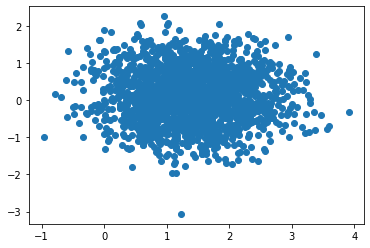

test samples: tensor([[ 1.2719,  0.0685],
        [ 1.2516, -0.2358],
        [ 1.3234, -0.7892],
        ...,
        [ 1.2448,  0.6915],
        [ 1.7330, -1.1091],
        [ 2.6581,  1.2300]])
auxil parameters: tensor([ 1.0000e+00,  1.0315e-04, -2.1520e-04,  9.9996e-01, -7.1409e-03,
         1.4431e-01], grad_fn=<CatBackward0>)
forward parameters: tensor([ 1.0000e+00,  1.0315e-04, -2.1520e-04,  9.9996e-01, -7.1409e-03,
         1.4431e-01], grad_fn=<CatBackward0>)
log det: tensor(-4.1984e-05, grad_fn=<LogBackward0>)
forward parameters: tensor([ 1.0000e+00,  1.0315e-04, -2.1520e-04,  9.9996e-01, -7.1409e-03,
         1.4431e-01], grad_fn=<CatBackward0>)
log det: tensor(-4.1984e-05, grad_fn=<LogBackward0>)
g1: (tensor([[1.2483e+05, 7.3881e+01],
        [1.0262e+04, 2.5033e+04]], grad_fn=<TBackward0>), tensor([70442.8973,  7320.5969], grad_fn=<ViewBackward0>))
initial residual
forward parameters: tensor([ 1.0000e+00,  1.0315e-04, -2.1520e-04,  9.9996e-01, -7.1409e-03,
         1.4431e-

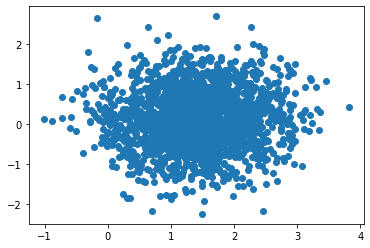

test samples: tensor([[ 2.1474, -0.5123],
        [ 2.1983,  0.4860],
        [ 0.6032, -0.3221],
        ...,
        [ 0.3988,  0.0448],
        [ 1.1368,  0.1793],
        [ 1.2661,  0.4398]])
auxil parameters: tensor([ 1.0000e+00,  1.0390e-04, -2.2154e-04,  9.9995e-01, -7.2841e-03,
         1.4573e-01], grad_fn=<CatBackward0>)
forward parameters: tensor([ 1.0000e+00,  1.0390e-04, -2.2154e-04,  9.9995e-01, -7.2841e-03,
         1.4573e-01], grad_fn=<CatBackward0>)
log det: tensor(-4.9403e-05, grad_fn=<LogBackward0>)
forward parameters: tensor([ 1.0000e+00,  1.0390e-04, -2.2154e-04,  9.9995e-01, -7.2841e-03,
         1.4573e-01], grad_fn=<CatBackward0>)
log det: tensor(-4.9403e-05, grad_fn=<LogBackward0>)
g1: (tensor([[124589.1086,   -154.0817],
        [ 10124.0327,  24772.5786]], grad_fn=<TBackward0>), tensor([70377.8376,  7186.8674], grad_fn=<ViewBackward0>))
initial residual
forward parameters: tensor([ 1.0000e+00,  1.0390e-04, -2.2154e-04,  9.9995e-01, -7.2841e-03,
         1.45

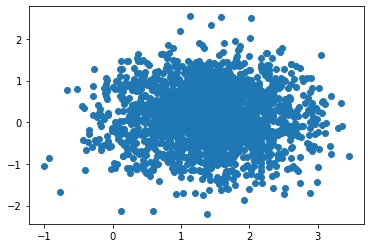

test samples: tensor([[ 2.1527, -0.2706],
        [ 0.6000, -0.9196],
        [ 2.0124,  1.4260],
        ...,
        [ 1.0869, -0.6106],
        [ 2.0393,  0.4166],
        [ 1.7367, -1.1826]])
auxil parameters: tensor([ 1.0000e+00,  1.0347e-04, -2.2459e-04,  9.9995e-01, -7.4283e-03,
         1.4714e-01], grad_fn=<CatBackward0>)
forward parameters: tensor([ 1.0000e+00,  1.0347e-04, -2.2459e-04,  9.9995e-01, -7.4283e-03,
         1.4714e-01], grad_fn=<CatBackward0>)
log det: tensor(-4.5628e-05, grad_fn=<LogBackward0>)
forward parameters: tensor([ 1.0000e+00,  1.0347e-04, -2.2459e-04,  9.9995e-01, -7.4283e-03,
         1.4714e-01], grad_fn=<CatBackward0>)
log det: tensor(-4.5628e-05, grad_fn=<LogBackward0>)
g1: (tensor([[1.2454e+05, 1.0877e+02],
        [1.0484e+04, 2.5064e+04]], grad_fn=<TBackward0>), tensor([70343.9870,  7496.3746], grad_fn=<ViewBackward0>))
initial residual
forward parameters: tensor([ 1.0000e+00,  1.0347e-04, -2.2459e-04,  9.9995e-01, -7.4283e-03,
         1.4714e-

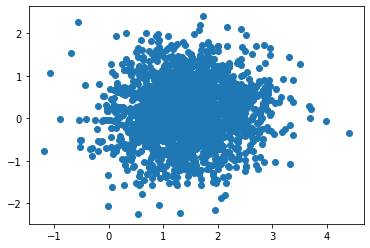

test samples: tensor([[ 1.0077,  0.8937],
        [ 2.0263,  0.6177],
        [ 1.8483, -1.4532],
        ...,
        [ 0.5126,  0.4886],
        [ 1.8549,  0.1859],
        [ 2.3010, -0.2933]])
auxil parameters: tensor([ 1.0000e+00,  1.0444e-04, -2.2620e-04,  9.9994e-01, -7.5736e-03,
         1.4855e-01], grad_fn=<CatBackward0>)
forward parameters: tensor([ 1.0000e+00,  1.0444e-04, -2.2620e-04,  9.9994e-01, -7.5736e-03,
         1.4855e-01], grad_fn=<CatBackward0>)
log det: tensor(-5.5477e-05, grad_fn=<LogBackward0>)
forward parameters: tensor([ 1.0000e+00,  1.0444e-04, -2.2620e-04,  9.9994e-01, -7.5736e-03,
         1.4855e-01], grad_fn=<CatBackward0>)
log det: tensor(-5.5477e-05, grad_fn=<LogBackward0>)
g1: (tensor([[ 1.2457e+05, -3.1031e+01],
        [ 1.0452e+04,  2.4930e+04]], grad_fn=<TBackward0>), tensor([70401.2228,  7365.3006], grad_fn=<ViewBackward0>))
initial residual
forward parameters: tensor([ 1.0000e+00,  1.0444e-04, -2.2620e-04,  9.9994e-01, -7.5736e-03,
         1.48

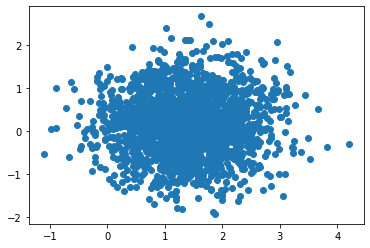

test samples: tensor([[ 2.1686, -1.4002],
        [ 1.4260,  0.4763],
        [ 1.4006,  0.9244],
        ...,
        [ 2.0348,  0.0063],
        [ 1.8469,  1.5770],
        [ 2.2325, -0.4508]])
auxil parameters: tensor([ 1.0000e+00,  1.0422e-04, -2.3141e-04,  9.9994e-01, -7.7209e-03,
         1.4996e-01], grad_fn=<CatBackward0>)
forward parameters: tensor([ 1.0000e+00,  1.0422e-04, -2.3141e-04,  9.9994e-01, -7.7209e-03,
         1.4996e-01], grad_fn=<CatBackward0>)
log det: tensor(-5.3619e-05, grad_fn=<LogBackward0>)
forward parameters: tensor([ 1.0000e+00,  1.0422e-04, -2.3141e-04,  9.9994e-01, -7.7209e-03,
         1.4996e-01], grad_fn=<CatBackward0>)
log det: tensor(-5.3619e-05, grad_fn=<LogBackward0>)
g1: (tensor([[ 1.2409e+05, -7.1425e+01],
        [ 1.0472e+04,  2.4973e+04]], grad_fn=<TBackward0>), tensor([70136.6634,  7435.2605], grad_fn=<ViewBackward0>))
initial residual
forward parameters: tensor([ 1.0000e+00,  1.0422e-04, -2.3141e-04,  9.9994e-01, -7.7209e-03,
         1.49

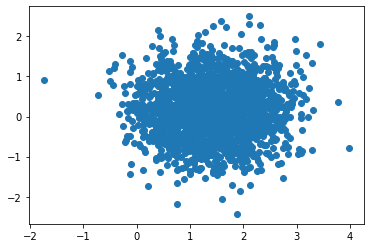

test samples: tensor([[ 1.5511, -0.5923],
        [ 0.8842,  1.0058],
        [ 2.7978, -1.4234],
        ...,
        [ 0.8113,  1.1866],
        [ 1.9246,  0.0859],
        [ 3.1334, -0.9698]])
auxil parameters: tensor([ 1.0000e+00,  1.0400e-04, -2.2220e-04,  9.9994e-01, -7.8675e-03,
         1.5135e-01], grad_fn=<CatBackward0>)
forward parameters: tensor([ 1.0000e+00,  1.0400e-04, -2.2220e-04,  9.9994e-01, -7.8675e-03,
         1.5135e-01], grad_fn=<CatBackward0>)
log det: tensor(-5.3263e-05, grad_fn=<LogBackward0>)
forward parameters: tensor([ 1.0000e+00,  1.0400e-04, -2.2220e-04,  9.9994e-01, -7.8675e-03,
         1.5135e-01], grad_fn=<CatBackward0>)
log det: tensor(-5.3263e-05, grad_fn=<LogBackward0>)
g1: (tensor([[124884.0210,    333.8022],
        [ 11029.1919,  24862.7496]], grad_fn=<TBackward0>), tensor([70463.9069,  7725.0343], grad_fn=<ViewBackward0>))
initial residual
forward parameters: tensor([ 1.0000e+00,  1.0400e-04, -2.2220e-04,  9.9994e-01, -7.8675e-03,
         1.51

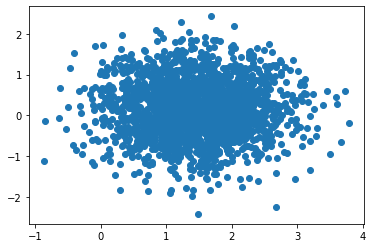

test samples: tensor([[ 9.7324e-01, -9.7908e-04],
        [ 1.8739e+00,  1.1335e+00],
        [ 1.6338e+00, -4.7555e-01],
        ...,
        [ 1.7855e+00, -7.1684e-01],
        [ 3.0032e+00,  4.9123e-01],
        [ 1.4520e+00, -2.5469e-01]])
auxil parameters: tensor([ 1.0000e+00,  1.0510e-04, -2.3170e-04,  9.9993e-01, -8.0183e-03,
         1.5277e-01], grad_fn=<CatBackward0>)
forward parameters: tensor([ 1.0000e+00,  1.0510e-04, -2.3170e-04,  9.9993e-01, -8.0183e-03,
         1.5277e-01], grad_fn=<CatBackward0>)
log det: tensor(-6.3304e-05, grad_fn=<LogBackward0>)
forward parameters: tensor([ 1.0000e+00,  1.0510e-04, -2.3170e-04,  9.9993e-01, -8.0183e-03,
         1.5277e-01], grad_fn=<CatBackward0>)
log det: tensor(-6.3304e-05, grad_fn=<LogBackward0>)
g1: (tensor([[124445.0214,   -255.2650],
        [ 10516.0627,  24837.1661]], grad_fn=<TBackward0>), tensor([70318.2863,  7484.6280], grad_fn=<ViewBackward0>))
initial residual
forward parameters: tensor([ 1.0000e+00,  1.0510e-04, -2.3

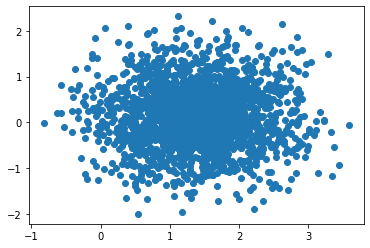

test samples: tensor([[ 2.2379, -0.0563],
        [ 0.9208, -1.0212],
        [ 1.1887, -0.8501],
        ...,
        [ 1.1843, -1.2427],
        [ 0.9948,  0.0947],
        [ 1.7443,  0.2734]])
auxil parameters: tensor([ 1.0000e+00,  1.0431e-04, -2.3346e-04,  9.9994e-01, -8.1693e-03,
         1.5418e-01], grad_fn=<CatBackward0>)
forward parameters: tensor([ 1.0000e+00,  1.0431e-04, -2.3346e-04,  9.9994e-01, -8.1693e-03,
         1.5418e-01], grad_fn=<CatBackward0>)
log det: tensor(-5.6631e-05, grad_fn=<LogBackward0>)
forward parameters: tensor([ 1.0000e+00,  1.0431e-04, -2.3346e-04,  9.9994e-01, -8.1693e-03,
         1.5418e-01], grad_fn=<CatBackward0>)
log det: tensor(-5.6631e-05, grad_fn=<LogBackward0>)
g1: (tensor([[123958.1449,    190.3535],
        [ 11043.0835,  25165.3358]], grad_fn=<TBackward0>), tensor([70173.0718,  7946.5234], grad_fn=<ViewBackward0>))
initial residual
forward parameters: tensor([ 1.0000e+00,  1.0431e-04, -2.3346e-04,  9.9994e-01, -8.1693e-03,
         1.54

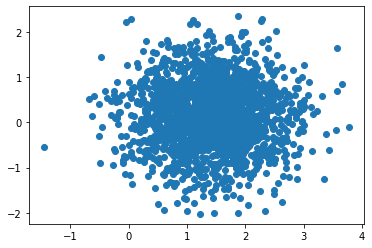

test samples: tensor([[ 1.1102, -0.0839],
        [ 1.7054, -0.4143],
        [ 0.0520, -0.3095],
        ...,
        [ 2.5403, -0.5981],
        [ 1.7205,  0.3354],
        [ 0.4450, -0.2817]])
auxil parameters: tensor([ 1.0000e+00,  1.0591e-04, -2.2757e-04,  9.9992e-01, -8.3206e-03,
         1.5558e-01], grad_fn=<CatBackward0>)
forward parameters: tensor([ 1.0000e+00,  1.0591e-04, -2.2757e-04,  9.9992e-01, -8.3206e-03,
         1.5558e-01], grad_fn=<CatBackward0>)
log det: tensor(-7.2725e-05, grad_fn=<LogBackward0>)
forward parameters: tensor([ 1.0000e+00,  1.0591e-04, -2.2757e-04,  9.9992e-01, -8.3206e-03,
         1.5558e-01], grad_fn=<CatBackward0>)
log det: tensor(-7.2725e-05, grad_fn=<LogBackward0>)
g1: (tensor([[124148.5516,   -216.8536],
        [ 10747.3561,  24814.0937]], grad_fn=<TBackward0>), tensor([70267.3205,  7564.8294], grad_fn=<ViewBackward0>))
initial residual
forward parameters: tensor([ 1.0000e+00,  1.0591e-04, -2.2757e-04,  9.9992e-01, -8.3206e-03,
         1.55

In [28]:

lstr=1e-6

t1 = time.time()

h_rec, pe_rec, ke_rec = np.zeros(niter), np.zeros(niter), np.zeros(niter)

log_ref_rho = gauss_log_rho
params['xi_lr'] = 0.
params['px_iters']=0
print("Running PWHF LSE with step size = ", dt)

for i in range(100):
    print("iteration:", i)
    ### NN solve step:
    if i%params['restart'] == 0:
        eta=None
    if True:#i%params['nshows']==0:
        print('number of iteration:', i)
        print(nn.utils.parameters_to_vector(flow2.parameters()))
        plot_samples, _ = sample_z(2000, 2, device=samples.device)
        draw_x, _ = flow2(plot_samples)
        draw_x = tensor_to_numpy(draw_x)
        plt.scatter(draw_x[:, 0], draw_x[:, 1])
        plt.show()
        plt.close()
        #traj_err = model_evaluation(flow, ho_sol, params, samples, samples, i*dt)
    relstr = lstr #/ np.sqrt(np.linalg.norm(pstate, 2))
    samples, sample_log_rho = sample_z(params['nsamples'], params['dim'], device=params['device'])
    print("test samples:", samples)
    print("auxil parameters:", nn.utils.parameters_to_vector(flow_auxil2.parameters()))
    ###d_alpha, d_p, G, s1 = relaxed_Lagrangian_dynamics(H_system, flow, flow_auxil, pstate, samples, lstr)

    xi, pstate, res, err = fixed_point_optim_solver(H_system, flow2, flow_auxil2, pstate, dt, samples, sample_log_rho, gauss_log_rho,
                                        relstr, params['px_iters'], params['xi_lr'], params['ls_solver_type'], eta, True, pe_samplesize=None)
    print("error", err)
    print("updated p:", pstate)
    print("current gradient:", xi)
    eta = xi
    alpha = nn.utils.parameters_to_vector(flow2.parameters()) + torch.Tensor(dt * xi).to(params['device'])
#     return alpha, pstate, res, err, xi, samples
#     newalpha, pstate, res, errrel, eta, samples = solver.step(H_system, flow, flow_auxil, pstate, 
#                                                               params, relstr, i,eta, params['print_type'], pe_samplesize=params['pe_samplesize'])
    ### Numerical solve step:
#     if params['potential_type']=='quadratic':
#         mu, sigma = ho_sol.Gauss_param(dt * i)    
#         xti = torch.matmul(xtest2, torch.Tensor(sigma).to(params['device']))
#         vti = None
#     else:
#         xti = torch.Tensor(tensor_to_numpy(xti)).to(params['device'])
#         xti, vti = H_system.numerical_step(xti, vti, dt)
#         #h_rec[i], pe_rec[i], ke_rec[i] = H_system.energy_eval(xti, vti)

    if False:#i%5==0:
        print("Values of parameters in the model:", nn.utils.parameters_to_vector(flow2.parameters()))
        npz = np.arange(-30, 30+0.01, 0.01).reshape(-1, 1)
        test_z = torch.Tensor(npz).to(params['device'])
        test_z_log_rho = gauss_log_rho(test_z)
        test_x, test_x_log_rho = flow2(test_z, test_z_log_rho)
#         plt.plot(npz, tensor_to_numpy(test_change_rho))
#         plt.show()
#         plt.close()
        
        test_gauss_z, _ = sample_z(50000, 1, True, params["device"])
        test_gauss_x, _ = flow2(test_gauss_z)
        plt.hist(tensor_to_numpy(test_gauss_x), bins=50, density=True)
        Gauss_rho = torch.exp(gauss_log_rho(test_z))
        plt.plot(tensor_to_numpy(test_z), tensor_to_numpy(Gauss_rho), label="Gauss rho")
        model_rho = torch.exp(test_x_log_rho)
        plt.plot(tensor_to_numpy(test_z), tensor_to_numpy(model_rho), label="model rho")
        plt.legend()
        plt.show()
        plt.close()

#     if i%params['nrec']==0:
#         theta_rec.append(tensor_to_numpy(nn.utils.parameters_to_vector(flow2.parameters())))
#         p_rec.append(pstate.reshape(-1))
#         rec_x, logr = flow2(test_points)
#         print('log rho:', logr)
#         np_recx = tensor_to_numpy(rec_x)
#         traj_rec.append( np_recx )
#         xtest_rec.append(tensor_to_numpy(xti[0:len_test, :]))#; vtest_rec.append(tensor_to_numpy(vti[0:len_test, :]))
        
#         if (i%params['n_savefig']==0)&(params['save']):
#             if params['potential_type']=='quadratic':
#                 #save_hist = os.path.join(save_path,  "sample histogram at {}-th step ".format(1+i))
#                 plot_projection(save_path, flow2, params, samples, mu, sigma, i, num=100)
#             plot_samples, _ = sample_z(2000, 2, device=samples.device)
#             draw_x, _ = flow2(plot_samples)
#             draw_x = tensor_to_numpy(draw_x)
#             plt.scatter(draw_x[:, 0], draw_x[:, 1])
#             filename_samples = os.path.join(save_path,  "(" + params['potential_type'] + ") " + "samples at {}-th step ".format(i))
#             plt.title("samples in {}-th step ".format(1+i))
#             plt.savefig(filename_samples)
#             plt.close()
        
#     if (i%params['nrec']==0) & (params['dim']<=2):
# #         wsamples = sample_z(5000, params['dim'], params['device'])
# #         wsamples = torch.matmul(wsamples, torch.Tensor(sigma).to(params['device']))

#         wsamples = xti[0:5000, :]
#         hsamples = sample_z(5000, 2, samples.device)
#         nnsamples, _ = flow(hsamples)
#         w2_eval = sinkh(wsamples, nnsamples)
#         #w2_eval = ot.emd2([], [], tensor_to_numpy(torch.cdist(x, y, p=2)))
#         w2_rec.append(tensor_to_numpy(w2_eval))

    #traj_err_rec[i] = eval_traj_error(samples, flow, sol_func)
#     hsamples, _ = sample_z(10000, 2, device=samples.device)
#     ke, pe = H_system.Hamiltonian_eval(flow2, flow_auxil2, torch.Tensor(eta).to(params['device']), hsamples)
#     KE_rec[i], PE_rec[i] = tensor_to_numpy(ke), tensor_to_numpy(pe)
#     H_rec[i] = KE_rec[i] + PE_rec[i] 
